In [1]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
"""
@File    :   phishing-graphs.ipynb
@Time    :   2023/03/30 21:02:43
@Author  :   Patricia Hernando Fernández 
@Version :   1.0
@Contact :   phf1001@alu.ubu.es
"""

'\n@File    :   phishing-graphs.ipynb\n@Time    :   2023/03/30 21:02:43\n@Author  :   Patricia Hernando Fernández \n@Version :   1.0\n@Contact :   phf1001@alu.ubu.es\n'

# **PHISHING EXPERIMENTS 🎣**

* Scores obtained using the proposed approach to detect phishing
* Graphs comparing ssl vs sl

In [2]:
import sys
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    recall_score,
    precision_score,
    auc,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

# Changing paths to src
src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(src_path)
from models.classifiers.DemocraticCoClassifier import DemocraticCo
from models.classifiers.TriTrainingClassifier import TriTraining
from models.classifiers.CoForestClassifier import CoForest

In [6]:
def get_clss(rd=5):
    # Random Forest
    random_forest_all = RandomForestClassifier(
        6, max_features="log2", random_state=rd
    )

    # Co Forest
    co_forest_six = CoForest(6, 0.75, max_features="log2", random_state=rd)
    co_forest_twenty = CoForest(20, 0.75, max_features="log2", random_state=rd)

    # Tri Training
    tri_training = TriTraining(
        DecisionTreeClassifier(random_state=rd),
        GaussianNB(),
        KNeighborsClassifier(),
        random_state=rd,
    )

    # Democratic Co
    democratic_co = DemocraticCo(
        [
            DecisionTreeClassifier(random_state=rd),
            GaussianNB(),
            KNeighborsClassifier(),
        ],
        random_state=rd,
    )

    cls = [
        random_forest_all,
        democratic_co,
        co_forest_six,
        co_forest_twenty,
        tri_training,
    ]

    cls_names = ["RF", "DC", "CoF_CLT", "CoF_PL", "TT"]

    return cls, cls_names

In [3]:
def get_first_last_feature(features):
    if features == "F1-F8":
        return 0, 8

    if features == "F9":
        return 8, 9

    if features == "F10-F15":
        return 9, 15

    if features == "F16":
        return 15, 16

    if features == "F17-F19":
        return 16, 19

    return 0, 19

In [4]:
def get_folds(features="all", rd=5, file_name="./fv/results-5_fvg3/mix.csv"):
    df = pd.read_csv(filepath_or_buffer=file_name)
    first_feature, last_feature = get_first_last_feature(features)
    X = df[df.columns[first_feature:last_feature]].values
    y = df.tag.values.astype(int)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

    return X, y, skf

In [5]:
def get_comparation_graph(
    cls,
    cls_names,
    X,
    y,
    skf,
    rd=5,
    y_low_lim=0,
    curve="ROC",
    used_features="F1-F19",
):
    fig, axes = plt.subplot_mosaic(
        "AAABBBCCC;AAADDDEEE", figsize=(10, 5), tight_layout=True
    )

    fig_2, axes_2 = plt.subplot_mosaic(
        "AABBCCDDEE", figsize=(10, 2), tight_layout=True
    )

    colours = ["#82e0aa", "#3eccf6", "#de88f3", "#f39c12", "#ff6961"]
    scores = []
    recalls = []
    precisions = []
    f1s = []
    AUCs = []
    y_true_total = []
    y_preds_total = {cls_name: [] for cls_name in cls_names}

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, _ = train_test_split(
            X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train
        )

        scores_experiment = []
        recalls_experiment = []
        precisions_experiment = []
        AUCs_experiment = []
        f1s_experiment = []

        for cl, cl_name in zip(cls, cls_names):
            if cl_name == "RF":
                # cl.fit(X_train, y_train)
                cl.fit(L_train, Ly_train)
            elif cl_name == "CoF_CLT":
                cl.fit(
                    L_train,
                    Ly_train,
                    U_train,
                    w_init_criteria="confidence_L_all",
                )
            elif cl_name == "CoF_PL":
                cl.fit(
                    L_train, Ly_train, U_train, w_init_criteria="percentage_L"
                )
            else:
                cl.fit(L_train, Ly_train, U_train)

            y_pred = cl.predict(X_test)
            scores_experiment.append(accuracy_score(y_test, y_pred))
            recalls_experiment.append(recall_score(y_test, y_pred))
            precisions_experiment.append(precision_score(y_test, y_pred))
            f1s_experiment.append(f1_score(y_test, y_pred))
            y_preds_total[cl_name] += list(y_pred)

            if curve == "ROC":
                fpr, tpr, _ = roc_curve(y_test, cl.predict_proba(X_test)[:, 1])
                AUCs_experiment.append(auc(fpr, tpr))

            else:
                precision, recall, _ = precision_recall_curve(
                    y_test, cl.predict_proba(X_test)[:, 1]
                )
                AUCs_experiment.append(auc(recall, precision))

        scores.append(scores_experiment)
        recalls.append(recalls_experiment)
        precisions.append(precisions_experiment)
        AUCs.append(AUCs_experiment)
        f1s.append(f1s_experiment)
        y_true_total += list(y_test)

    for ax in (axes, axes_2):
        ax["A"].set_ylabel("Accuracy")
        ax["A"].set_ylim(y_low_lim, 1.0)
        ax["A"].bar(cls_names, np.mean(scores, axis=0), color=colours)

        ax["B"].set_ylabel("Recall")
        ax["B"].set_ylim(y_low_lim, 1.0)
        ax["B"].bar(cls_names, np.mean(recalls, axis=0), color=colours)

        ax["C"].set_ylabel("Precision")
        ax["C"].set_ylim(y_low_lim, 1.0)
        ax["C"].bar(cls_names, np.mean(precisions, axis=0), color=colours)

        ax["D"].set_ylabel("F1")
        ax["D"].set_ylim(y_low_lim, 1.0)
        ax["D"].bar(cls_names, np.mean(f1s, axis=0), color=colours)

        ax["E"].set_ylabel("AUC")
        ax["E"].set_ylim(y_low_lim, 1.0)
        ax["E"].bar(cls_names, np.mean(AUCs, axis=0), color=colours)

        for i in ["A", "B", "C", "D", "E"]:
            ax[i].set_xticklabels(cls_names, rotation=45, ha="right")

    print("Resultados {}".format(used_features))
    plt.plot()

    accuracys = np.mean(scores, axis=0)
    recalls = np.mean(recalls, axis=0)
    precisions = np.mean(precisions, axis=0)
    AUCs = np.mean(AUCs, axis=0)
    f1s = np.mean(f1s, axis=0)

    scores_clss = {
        cls: {
            metric: []
            for metric in ["Accuracy", "Recall", "Precision", "F1", "AUC"]
        }
        for cls in cls_names
    }

    for i, cls_name in enumerate(cls_names):
        scores_clss[cls_name]["Accuracy"].append(accuracys[i])
        scores_clss[cls_name]["Recall"].append(recalls[i])
        scores_clss[cls_name]["Precision"].append(precisions[i])
        scores_clss[cls_name]["F1"].append(f1s[i])
        scores_clss[cls_name]["AUC"].append(AUCs[i])

    with open(f"results_{used_features}.json", "w") as f:
        f.write(json.dumps(scores_clss, indent=4))
    f.close()

    return y_true_total, y_preds_total

In [7]:
def plot_confusion_matrix(y_true, y_pred, cls_name):
    matrix = confusion_matrix(y_true, y_pred)
    sorted_labels = ["Legítimo", "Phishing"]
    plt.figure(figsize=(6.4, 3))
    sns.heatmap(
        matrix,
        annot=True,
        cmap="Blues",
        fmt="g",
        xticklabels=sorted_labels,
        yticklabels=sorted_labels,
    )
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    print("Matriz de confusión clasificador {}".format(cls_name))
    plt.show()

In [8]:
def plot_important_atributes(X, y, max_depth=None):
    if max_depth:
        cls = DecisionTreeClassifier(max_depth=max_depth)

    else:
        cls = DecisionTreeClassifier()

    cls.fit(X, y)
    plt.figure(figsize=(20, 20))
    tree.plot_tree(cls)
    plt.savefig("tree_high_dpi", dpi=100)

In [9]:
def plot_rf_feature_importance(
    features="all", rd=5, file_name="./fv/results-5_fvg3/mix.csv"
):
    df = pd.read_csv(filepath_or_buffer=file_name)

    first_feature, last_feature = get_first_last_feature(features)
    atributes = df.columns[first_feature:last_feature]
    target = df.columns[-1]

    rf = RandomForestClassifier(n_estimators=5000, n_jobs=-1, random_state=rd)
    rf.fit(df[atributes], df[target])

    features = []

    for atribute in atributes:
        if len(atribute) == 3:
            features.append(atribute)
        else:
            features.append(atribute[0] + "0" + atribute[1])

    importances = rf.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 6))

    plt.barh(
        range(len(indices)),
        importances[indices],
        color="#a8aff3",
        align="center",
    )
    plt.yticks(range(len(indices)), [features[i].upper() for i in indices])
    plt.xlabel("Importancia relativa")
    plt.show()

### **LINES GRAPH**

In [10]:
def get_scores(
    cls, cls_names, X, y, skf, rd=5, curve="ROC", percentage_labels=0.8
):
    scores = []
    recalls = []
    precisions = []
    f1s = []
    AUCs = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(
            X_train,
            y_train,
            train_size=percentage_labels,
            random_state=rd,
            stratify=y_train,
        )

        scores_experiment = []
        recalls_experiment = []
        precisions_experiment = []
        AUCs_experiment = []
        f1s_experiment = []

        for cl, cl_name in zip(cls, cls_names):
            if cl_name == "RF":
                cl.fit(L_train, Ly_train)

            elif cl_name == "CoF_CLT":
                cl.fit(
                    L_train,
                    Ly_train,
                    U_train,
                    w_init_criteria="confidence_L_all",
                )
            elif cl_name == "CoF_PL":
                cl.fit(
                    L_train, Ly_train, U_train, w_init_criteria="percentage_L"
                )
            else:
                cl.fit(L_train, Ly_train, U_train)

            y_pred = cl.predict(X_test)
            scores_experiment.append(accuracy_score(y_test, y_pred))
            recalls_experiment.append(recall_score(y_test, y_pred))
            precisions_experiment.append(precision_score(y_test, y_pred))
            f1s_experiment.append(f1_score(y_test, y_pred))

            if curve == "ROC":
                fpr, tpr, _ = roc_curve(y_test, cl.predict_proba(X_test)[:, 1])
                AUCs_experiment.append(auc(fpr, tpr))

            else:
                precision, recall, _ = precision_recall_curve(
                    y_test, cl.predict_proba(X_test)[:, 1]
                )
                AUCs_experiment.append(auc(recall, precision))

        scores.append(scores_experiment)
        recalls.append(recalls_experiment)
        precisions.append(precisions_experiment)
        AUCs.append(AUCs_experiment)
        f1s.append(f1s_experiment)

    accuracys = np.mean(scores, axis=0)
    recalls = np.mean(recalls, axis=0)
    precisions = np.mean(precisions, axis=0)
    AUCs = np.mean(AUCs, axis=0)
    f1s = np.mean(f1s, axis=0)

    return accuracys, recalls, precisions, f1s, AUCs

In [21]:
def run_all_scores(percentages, metrics):
    _, cls_names = get_clss()
    scores_clss = {cls: {metric: [] for metric in metrics} for cls in cls_names}

    for i in percentages:
        clss, cls_names = get_clss()
        X, y, skf = get_folds("all", file_name="./fv/results-5_fvg3/mix.csv")

        accuracys, recalls, precisions, f1s, AUCs = get_scores(
            clss, cls_names, X, y, skf, curve="ROC", percentage_labels=i
        )

        for i, cls_name in enumerate(cls_names):
            scores_clss[cls_name]["Accuracy"].append(accuracys[i])
            scores_clss[cls_name]["Recall"].append(recalls[i])
            scores_clss[cls_name]["Precision"].append(precisions[i])
            scores_clss[cls_name]["F1"].append(f1s[i])
            scores_clss[cls_name]["AUC"].append(AUCs[i])

    with open("results_classifiers.txt", "w") as f:
        f.write(json.dumps(scores_clss, indent=4))
    f.close()

    return scores_clss


def get_evolution_graph(
    y_low_lim=0.6,
    y_high_lim=1.0,
    from_file=False,
    file_name="results_classifiers_repeated_kcross_mean_10",
):
    _, cls_names = get_clss()
    percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    percentage_labels = ["10", "20", "30", "40", "50", "60", "70", "80", "90"]
    metrics = ["Accuracy", "Recall", "Precision", "F1", "AUC"]

    if from_file:
        with open(file_name, "r") as f:
            scores_clss = json.load(f)
            f.close()

    else:
        scores_clss = run_all_scores(percentages, metrics)

    fig, axes = plt.subplot_mosaic(
        "AA;BB;CC;DD", figsize=(10, 20), tight_layout=True
    )

    colours = ["#82e0aa", "#3eccf6", "#de88f3", "#f39c12", "#ff6961"]
    markers = ["o", "v", "s", "P", "*"]

    for metric, ax in zip(metrics, ["A", "B", "C", "D"]):
        fig_2, axes_2 = plt.subplot_mosaic(
            "AAAAAAA;AAAAAAA", figsize=(10, 6), tight_layout=True
        )

        for i, cls in enumerate(scores_clss):
            if cls == "RF":
                linestyle = (0, (5, 10))
            else:
                linestyle = "-"

            for _, obj in enumerate([axes_2["A"], axes[ax]]):
                obj.plot(
                    percentage_labels,
                    scores_clss[cls][metric],
                    color=colours[i],
                    linestyle=linestyle,
                    marker=markers[i],
                    linewidth=0.8,
                    label=cls,
                )

                obj.set_ylabel(metric)

                obj.set_xlabel(
                    "Instancias etiquetadas en el conjunto de entrenamiento (%)"
                )
                if y_low_lim and y_high_lim:
                    obj.set_ylim(y_low_lim, y_high_lim)

                fig_2.legend(
                    cls_names,
                    bbox_to_anchor=(0.5, 1.05),
                    loc="upper center",
                    ncol=len(cls_names),
                )

    fig.legend(
        cls_names,
        bbox_to_anchor=(0.5, 1.02),
        loc="upper center",
        ncol=len(cls_names),
    )

    plt.plot()

## **EXPERIMENTS**

In [12]:
# get_evolution_graph()

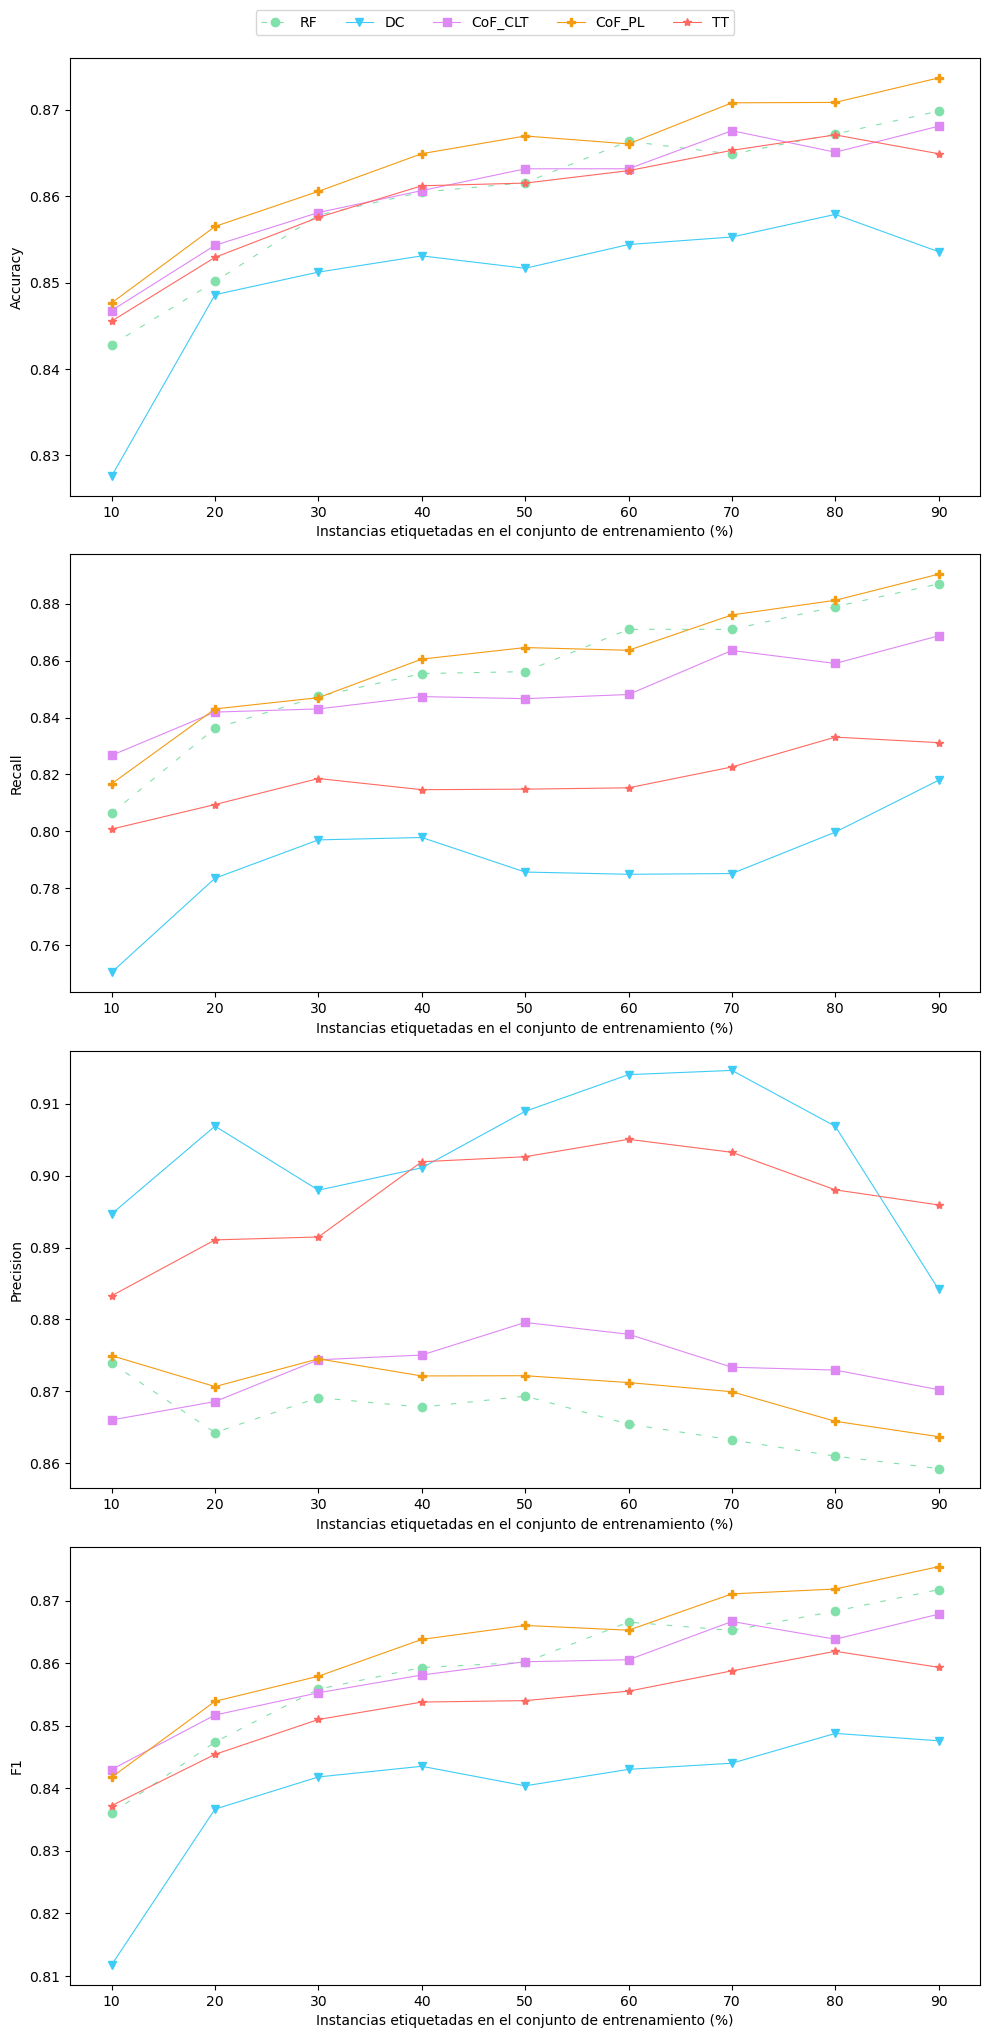

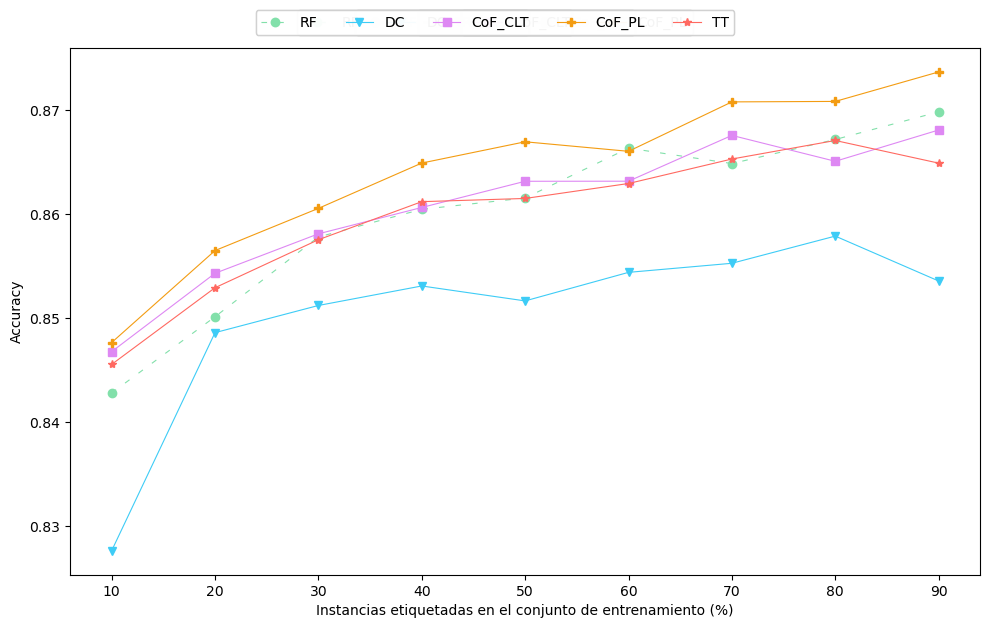

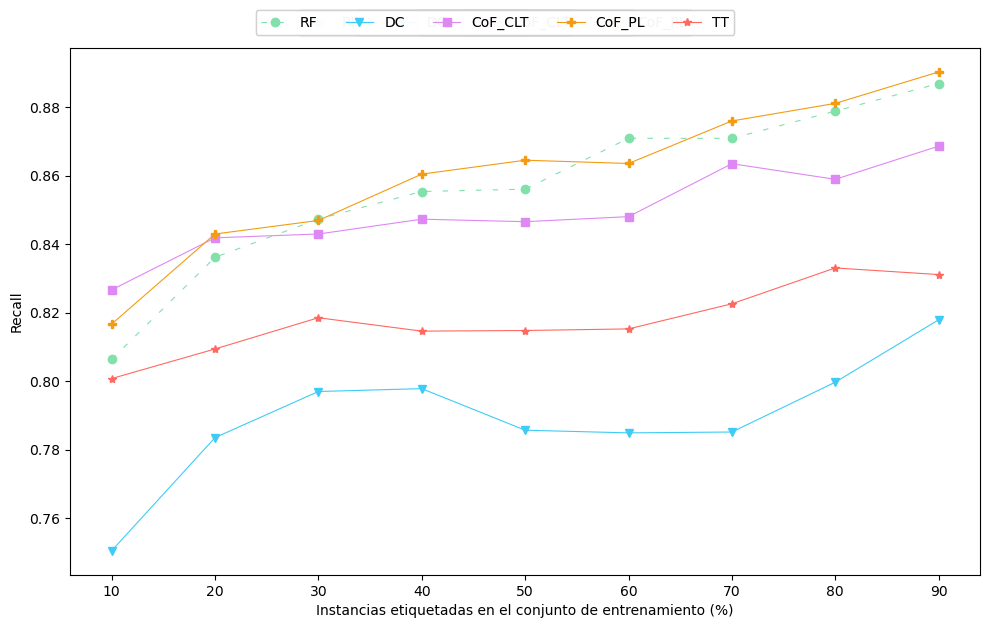

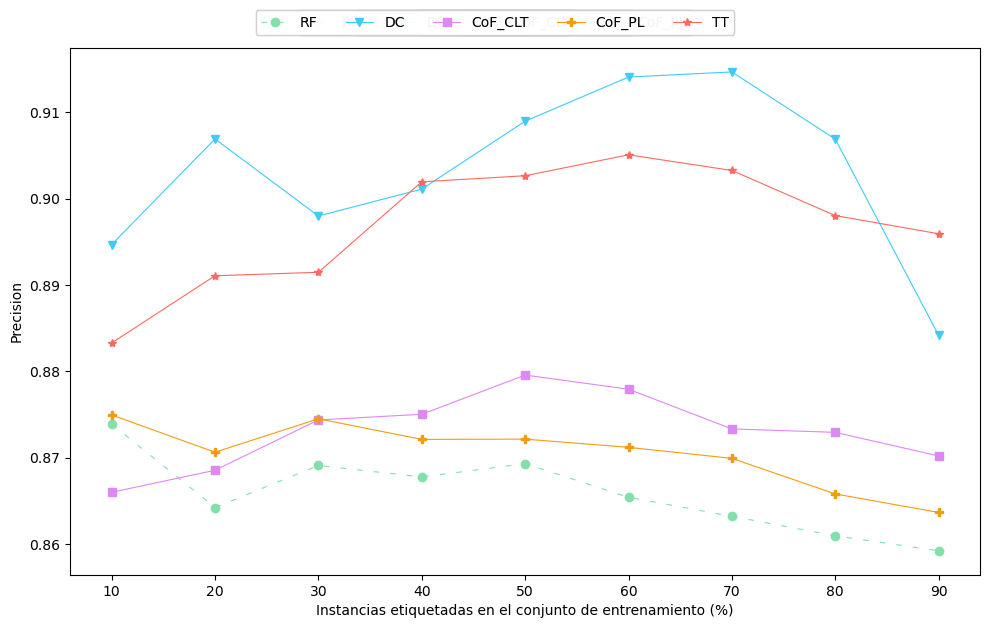

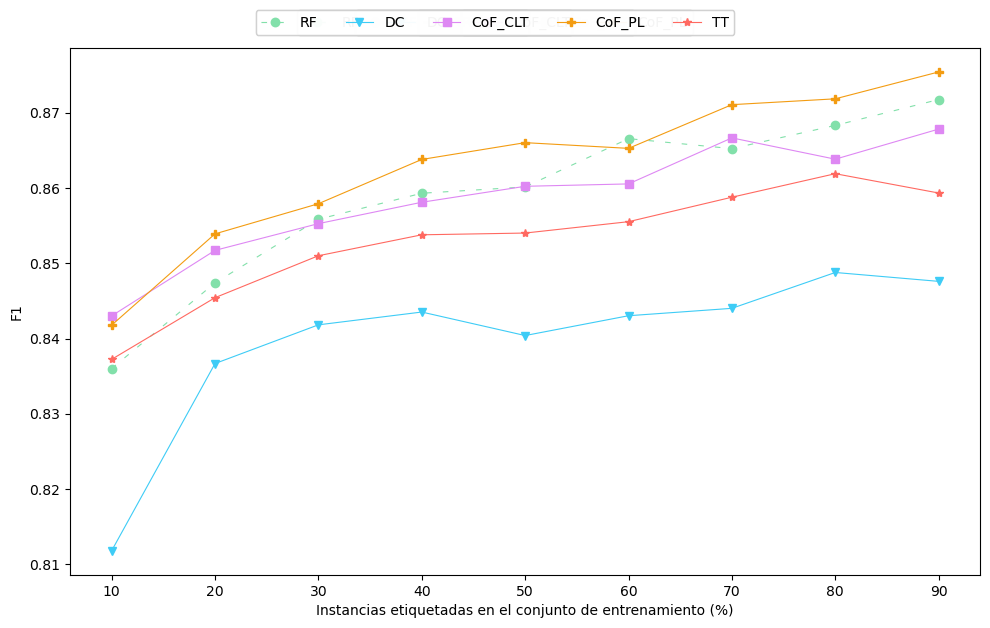

In [22]:
# File is the result from executing repeated kcross
get_evolution_graph(
    None,
    None,
    from_file=True,
    file_name="results/ssl_vs_sl/ssl_vs_sl-1/results_classifiers_repeated_kcross_mean_10.json",
)

In [14]:
def run_all(used_features="all"):
    clss, cls_names = get_clss()
    X, y, skf = get_folds(
        used_features
    )  # , file_name="./fv/results-5_fvg3/mix_small.csv"
    y_true_total, y_preds_total = get_comparation_graph(
        clss,
        cls_names,
        X,
        y,
        skf,
        curve="ROC",
        used_features=used_features,
        y_low_lim=0.5,
    )

    for cls_name in cls_names:
        plot_confusion_matrix(
            y_true_total, y_preds_total[cls_name], cls_name=cls_name
        )

    plot_important_atributes(X, y)
    plot_important_atributes(X, y, max_depth=3)
    plot_rf_feature_importance(used_features)

Resultados all
Matriz de confusión clasificador RF


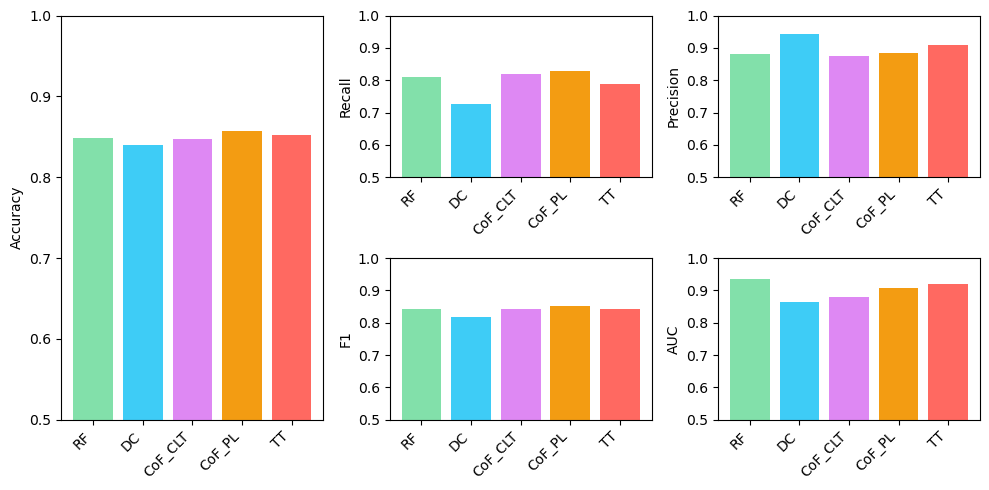

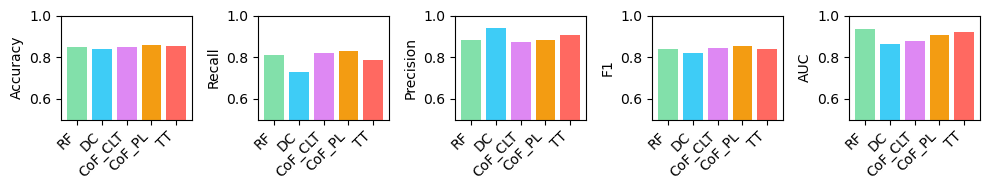

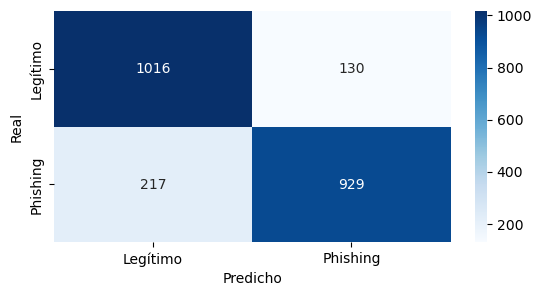

Matriz de confusión clasificador DC


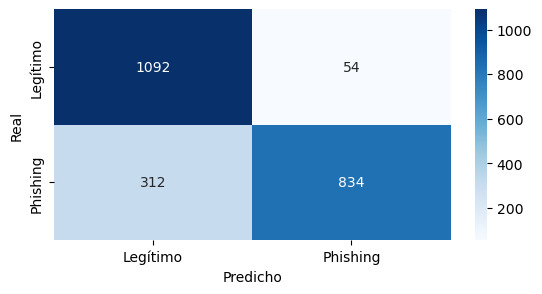

Matriz de confusión clasificador CoF_CLT


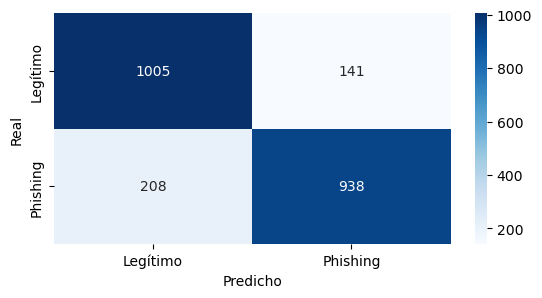

Matriz de confusión clasificador CoF_PL


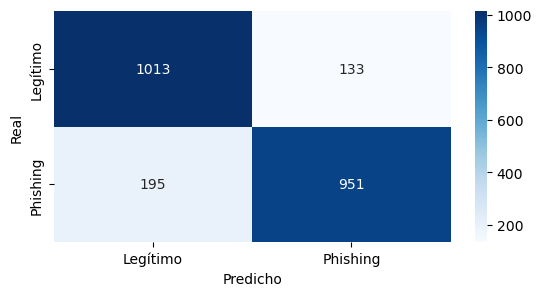

Matriz de confusión clasificador TT


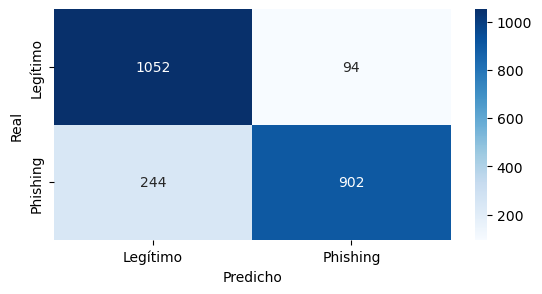

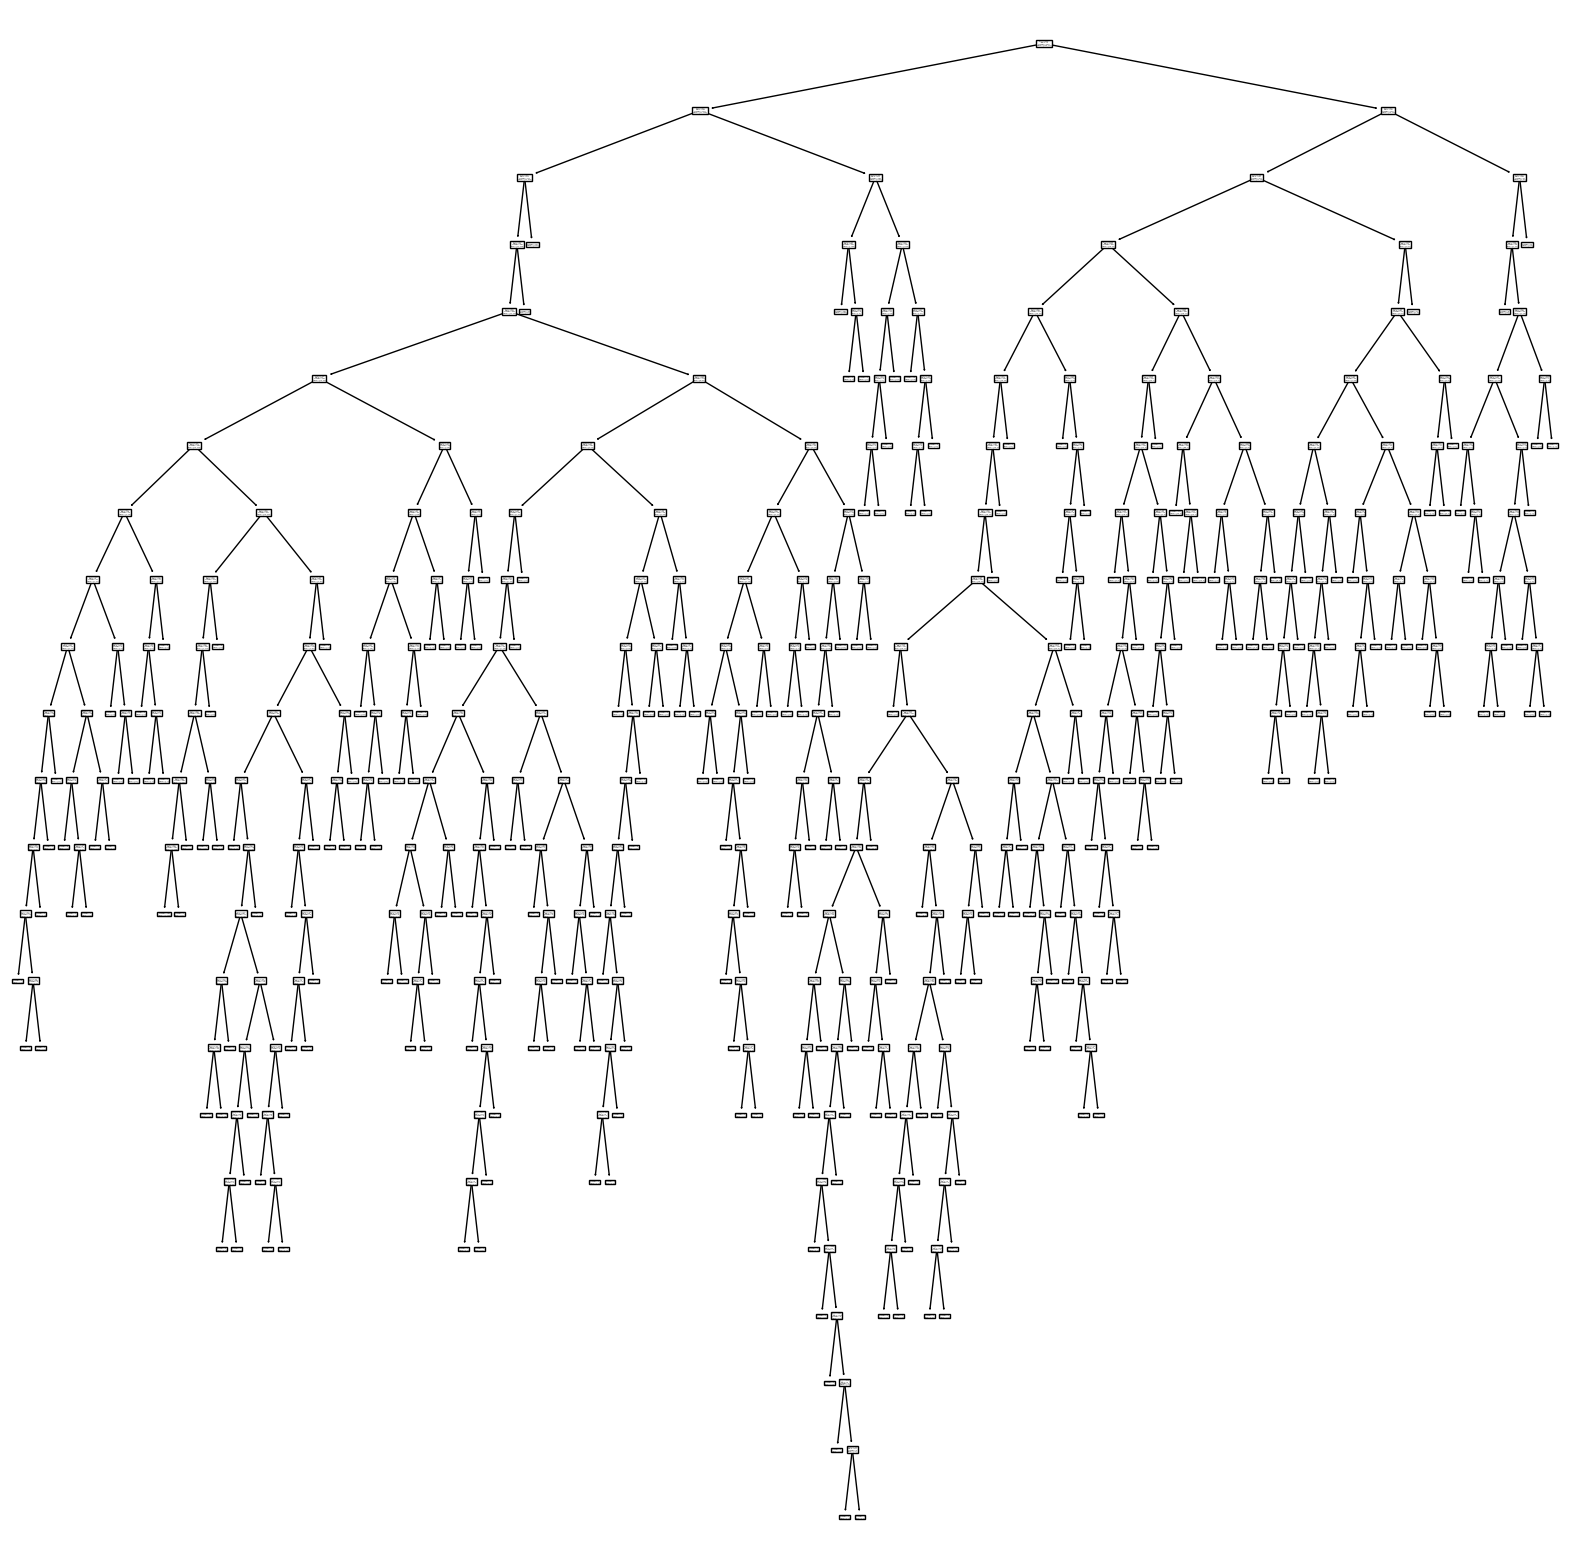

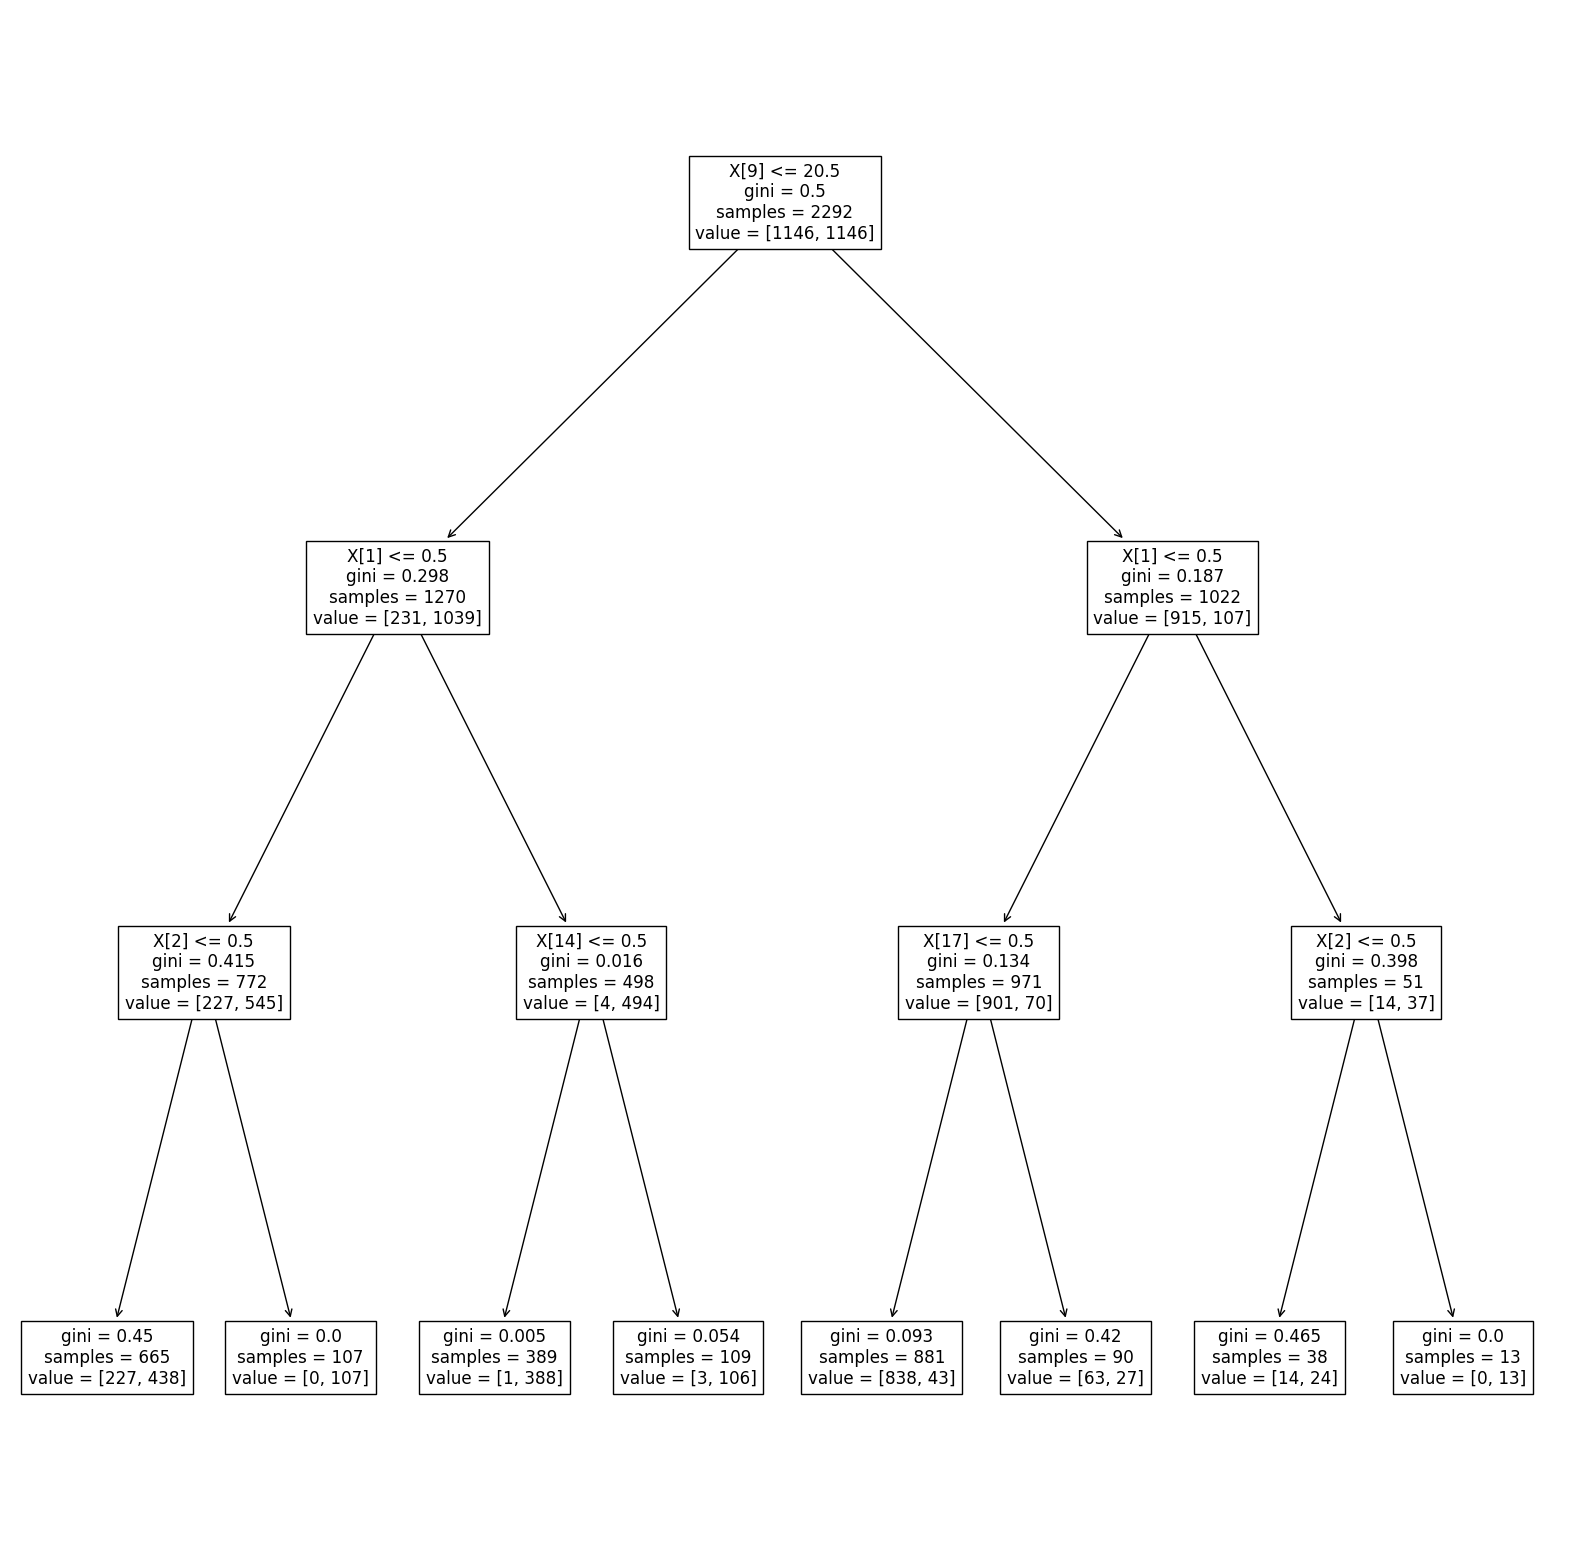

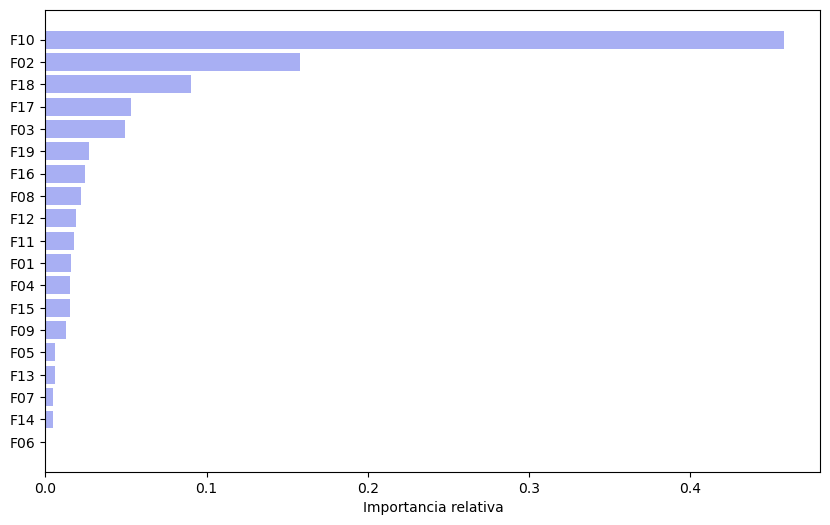

In [15]:
used_features = "all"
run_all(used_features)

Resultados F1-F8
Matriz de confusión clasificador RF


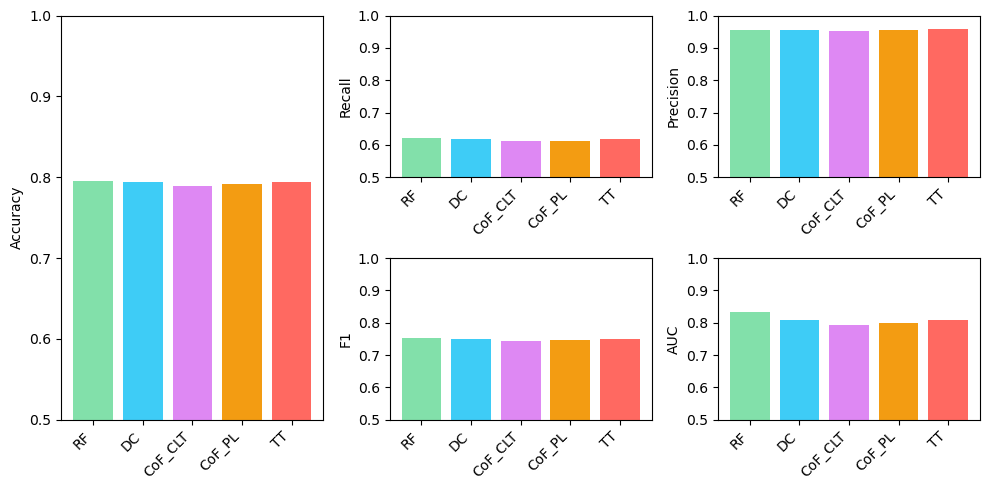

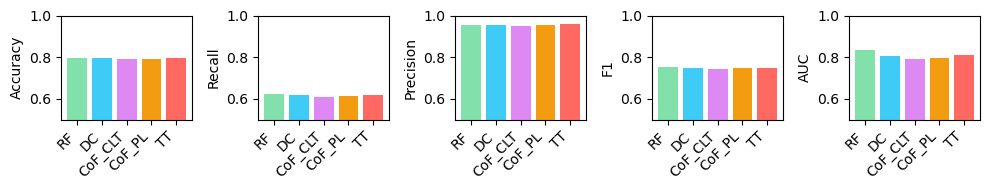

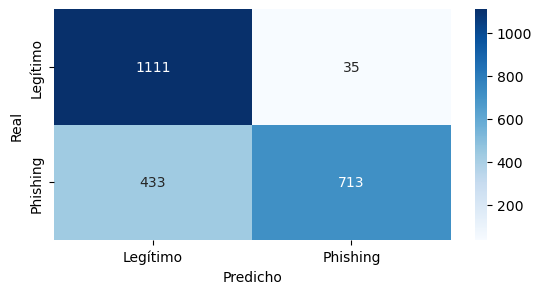

Matriz de confusión clasificador DC


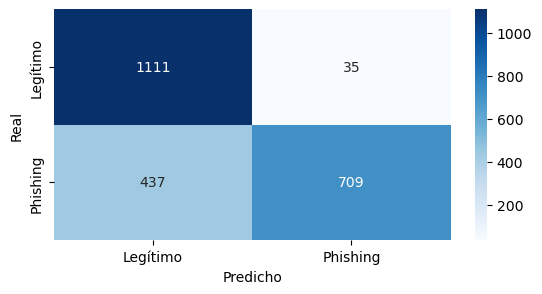

Matriz de confusión clasificador CoF_CLT


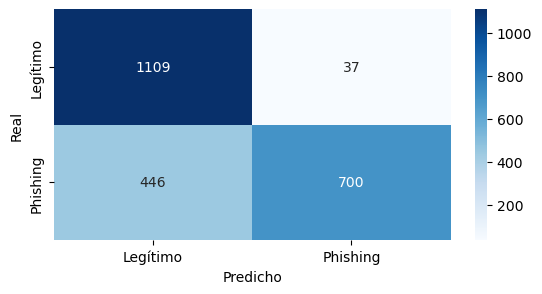

Matriz de confusión clasificador CoF_PL


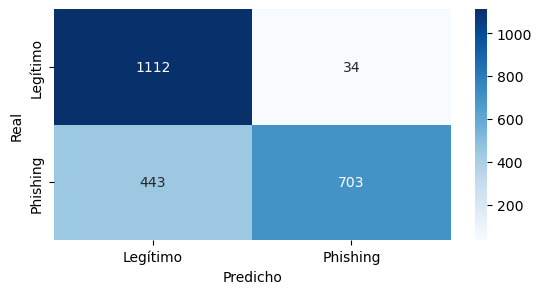

Matriz de confusión clasificador TT


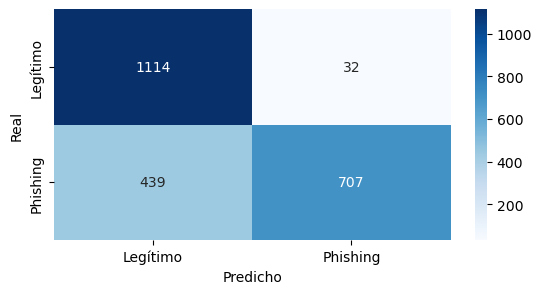

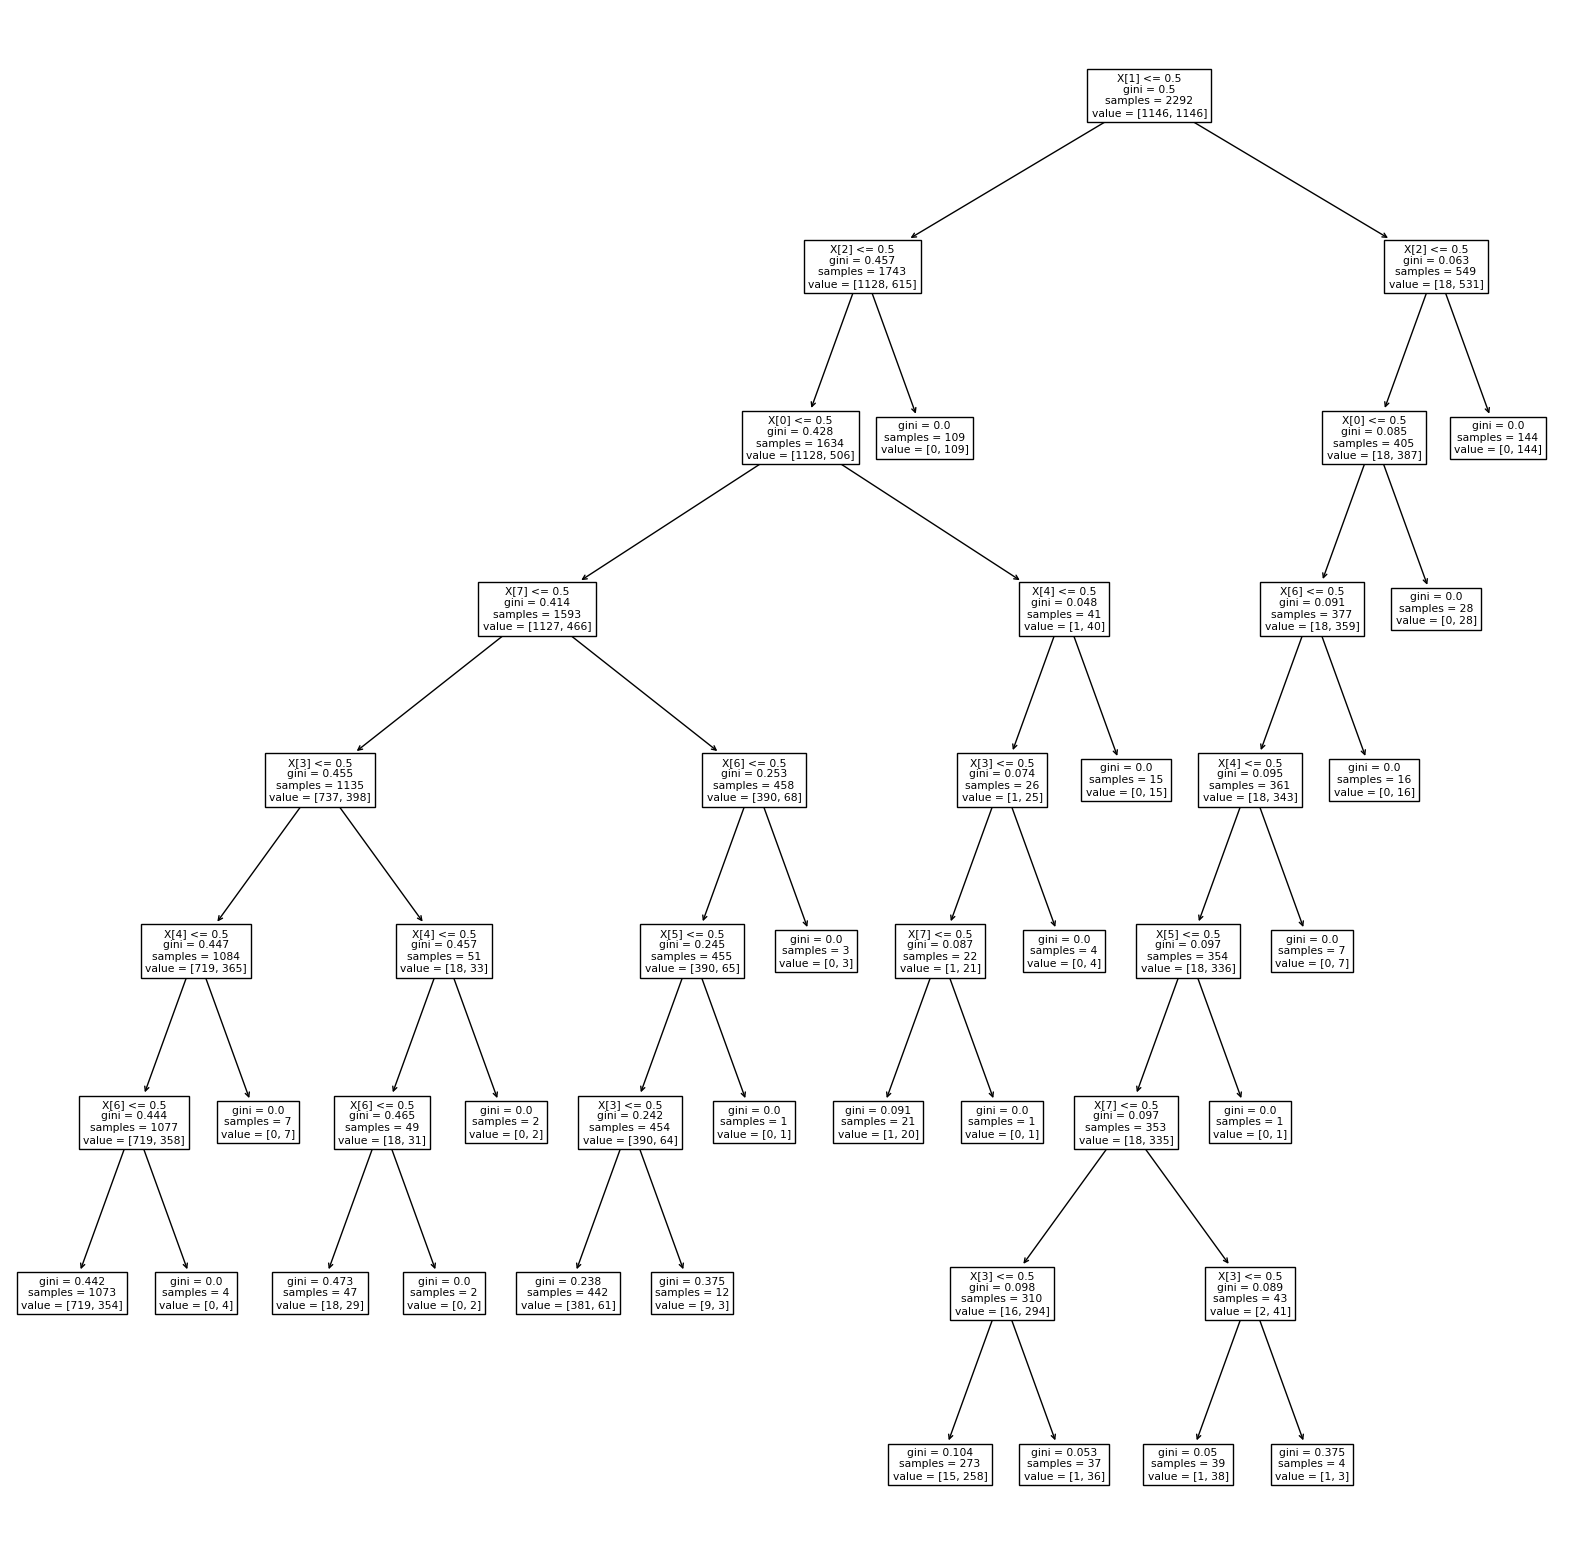

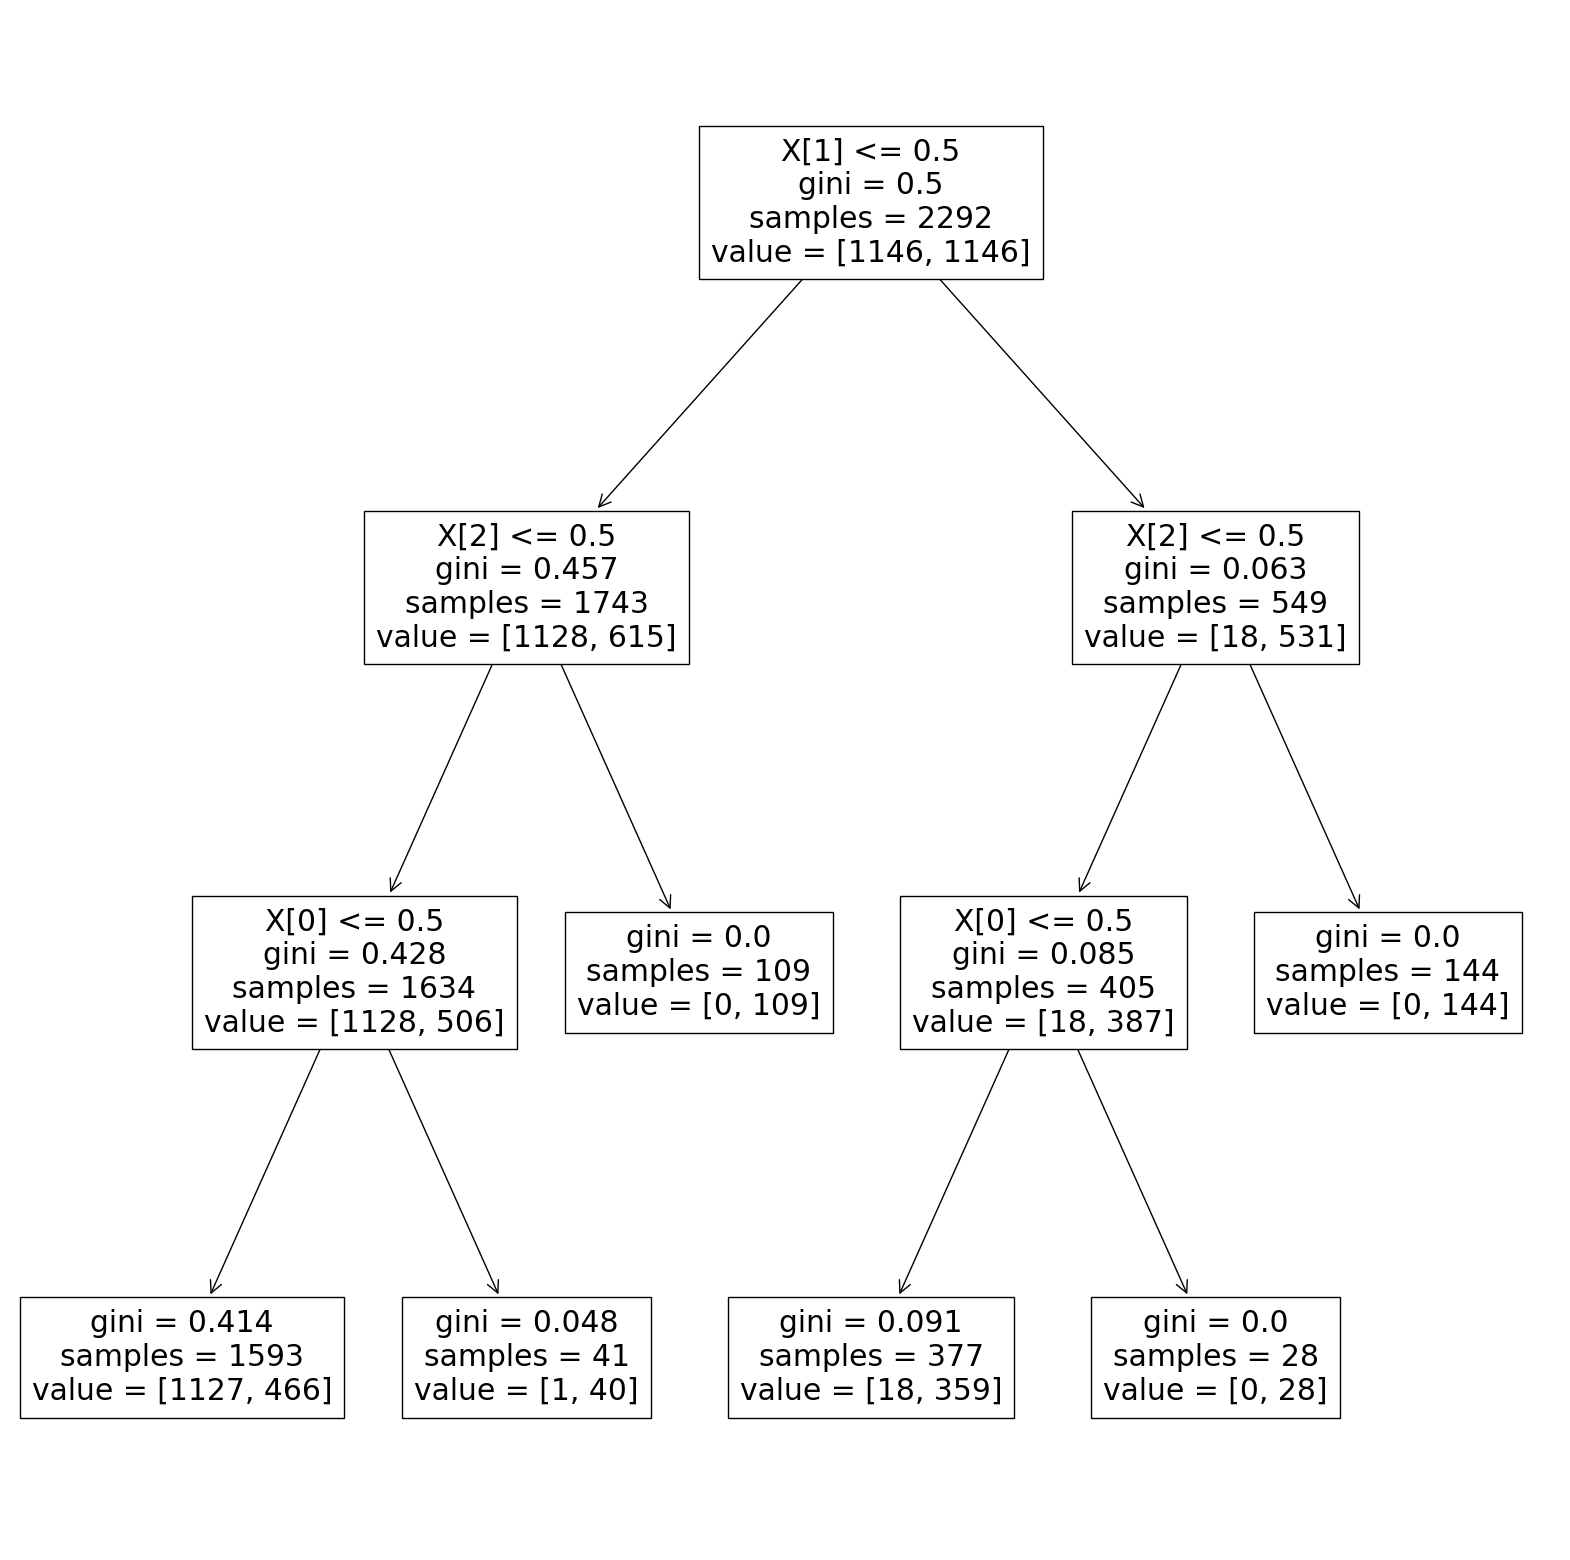

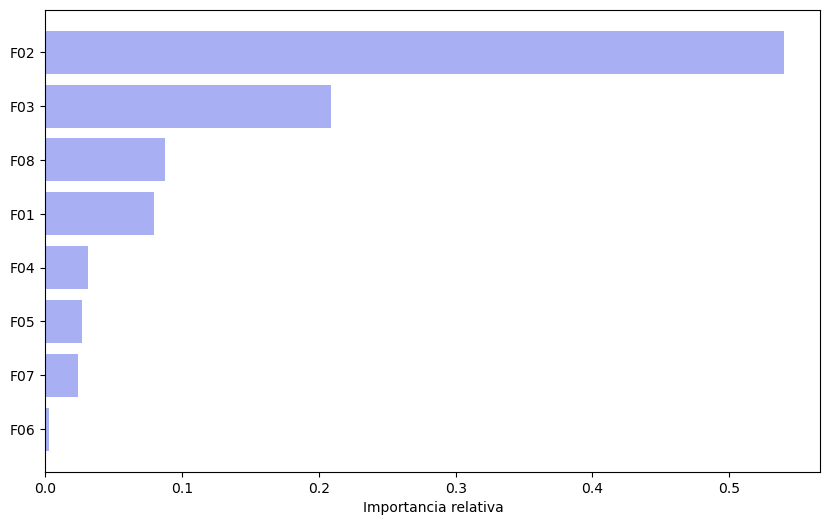

In [16]:
used_features = "F1-F8"
run_all(used_features)

Resultados F9
Matriz de confusión clasificador RF


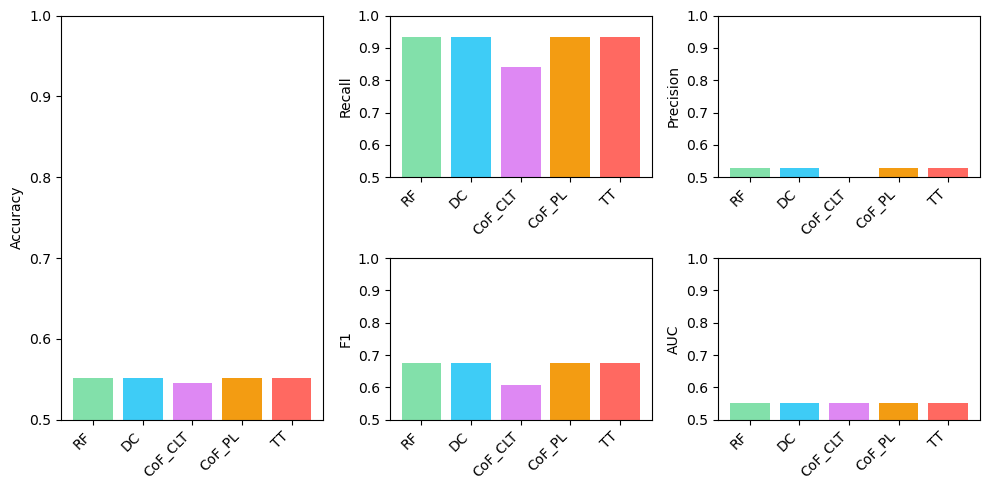

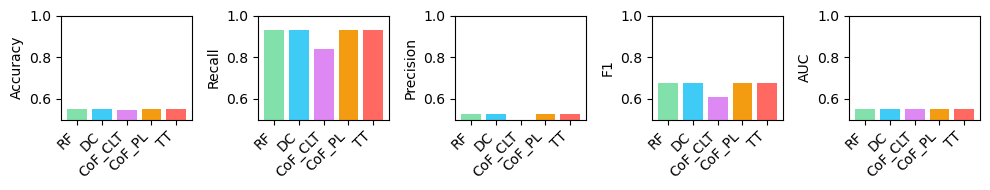

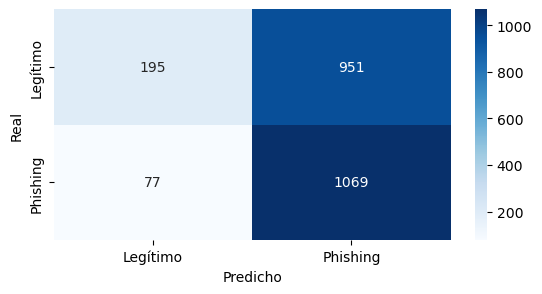

Matriz de confusión clasificador DC


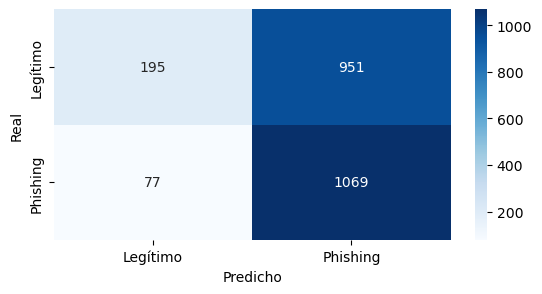

Matriz de confusión clasificador CoF_CLT


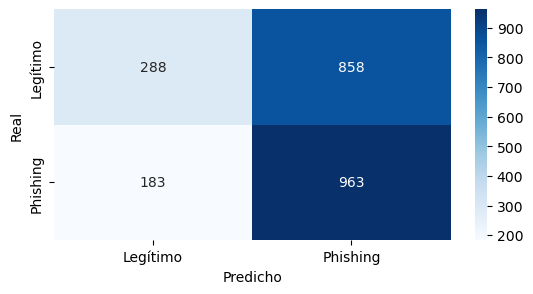

Matriz de confusión clasificador CoF_PL


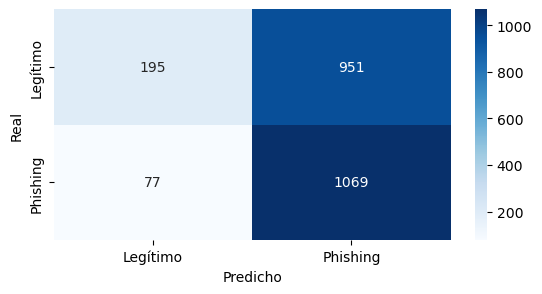

Matriz de confusión clasificador TT


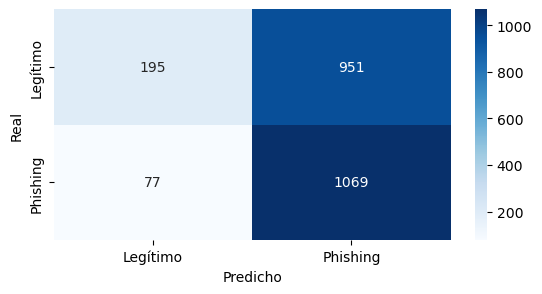

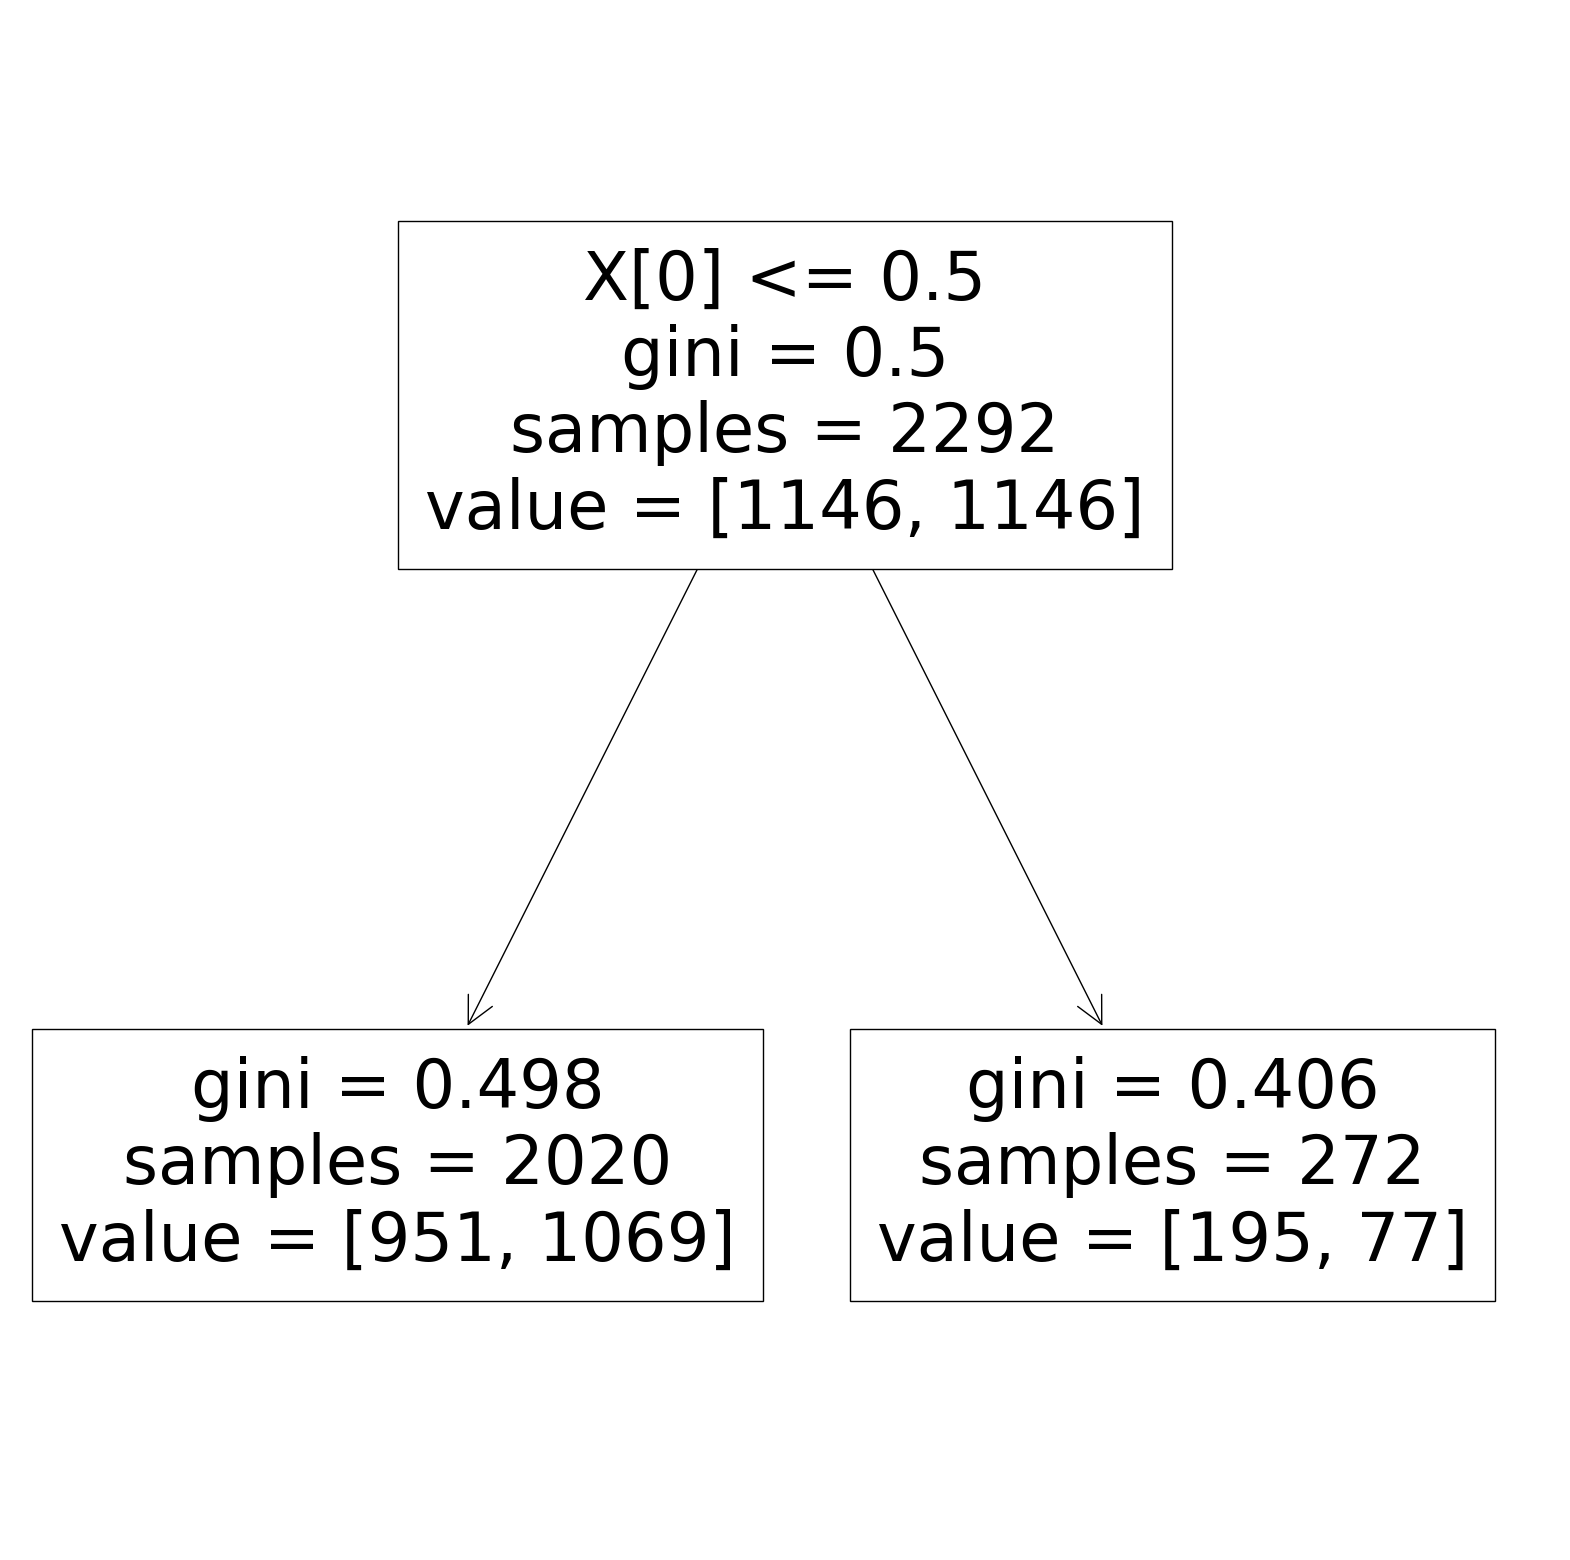

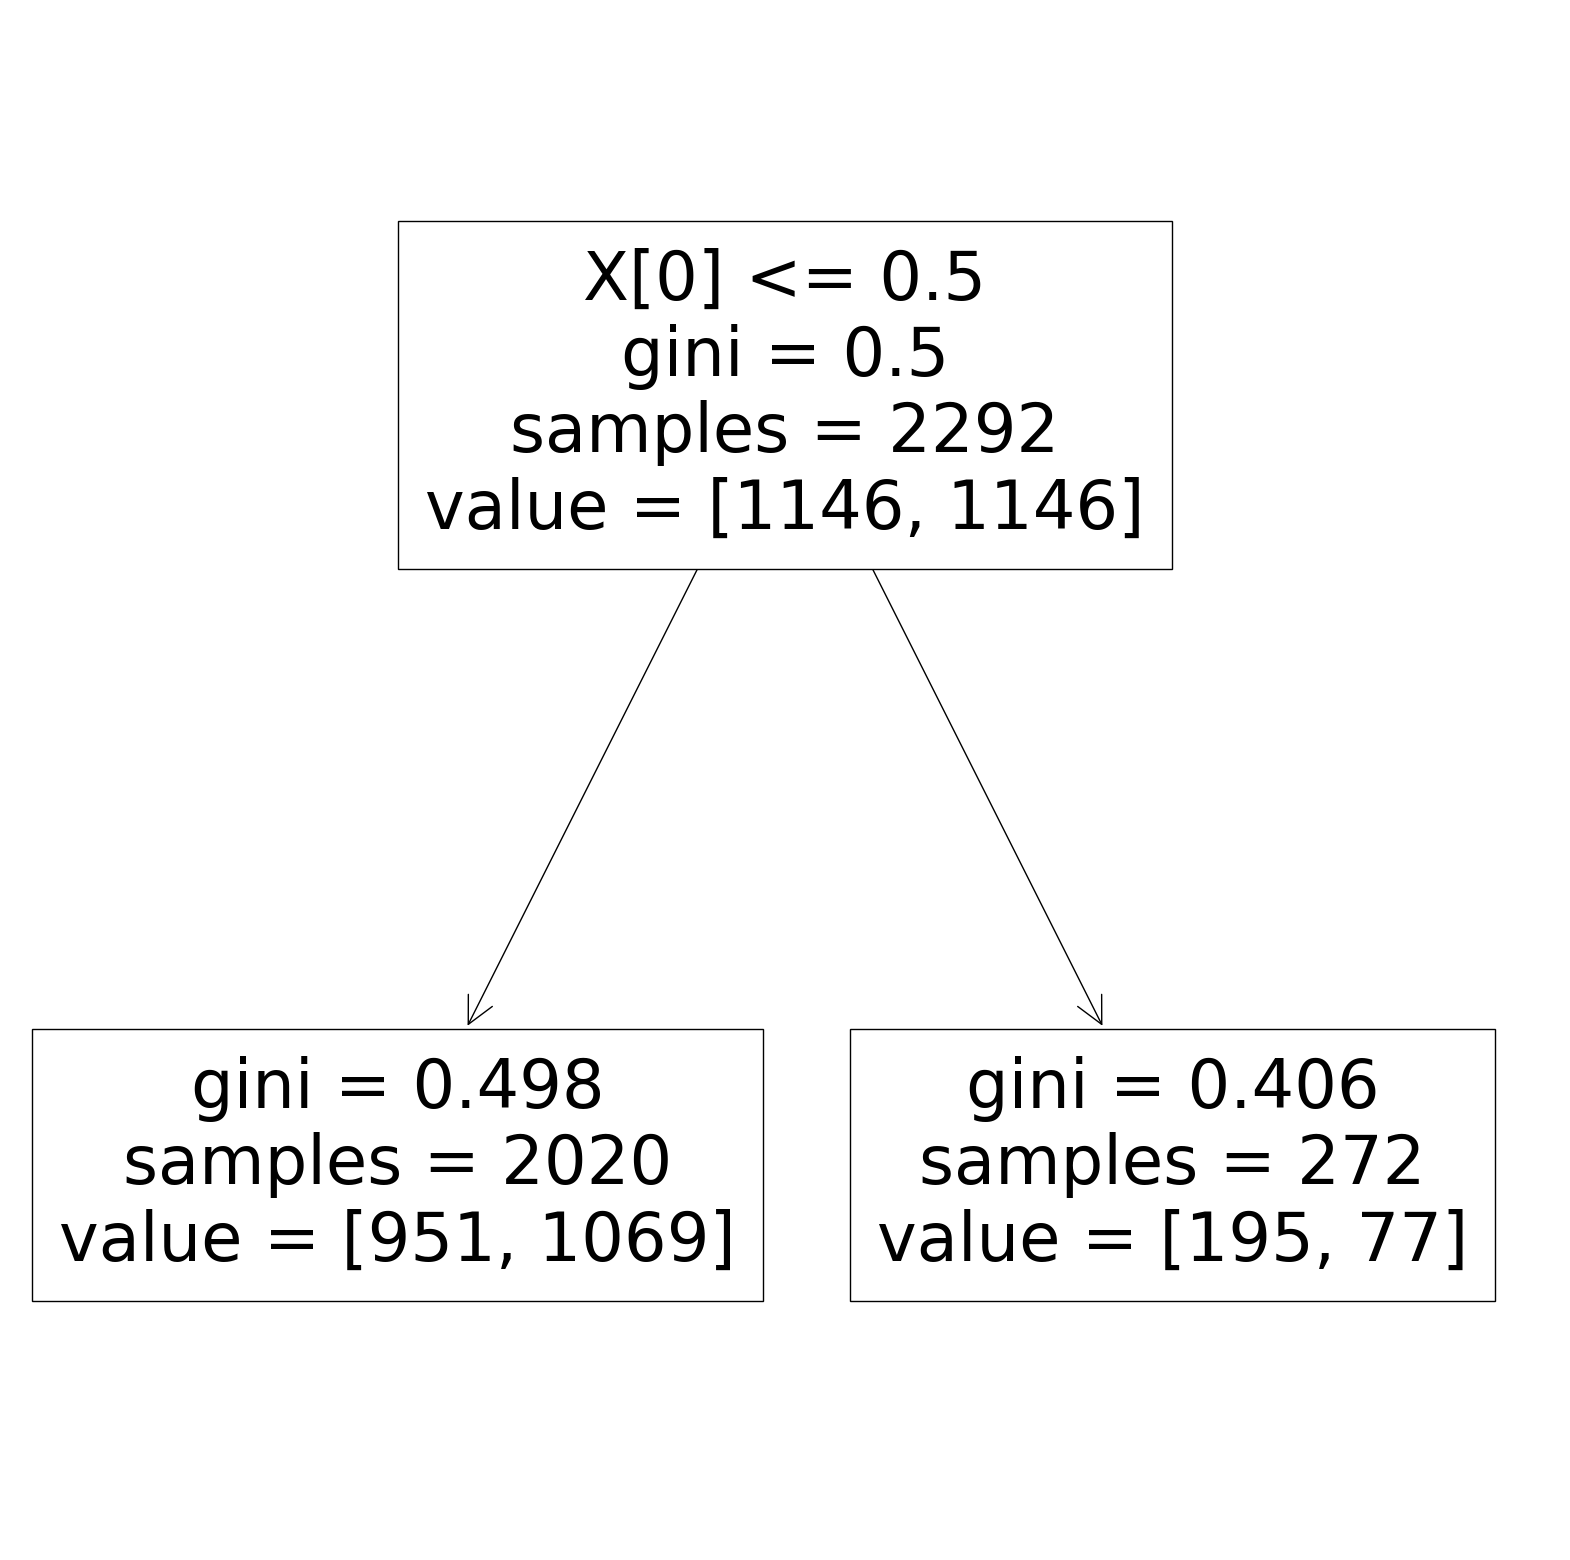

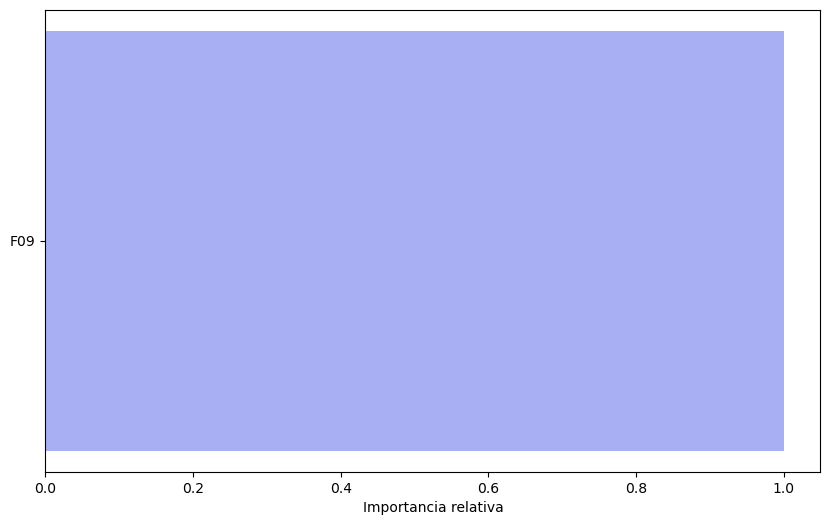

In [17]:
used_features = "F9"
run_all(used_features)

Resultados F10-F15
Matriz de confusión clasificador RF


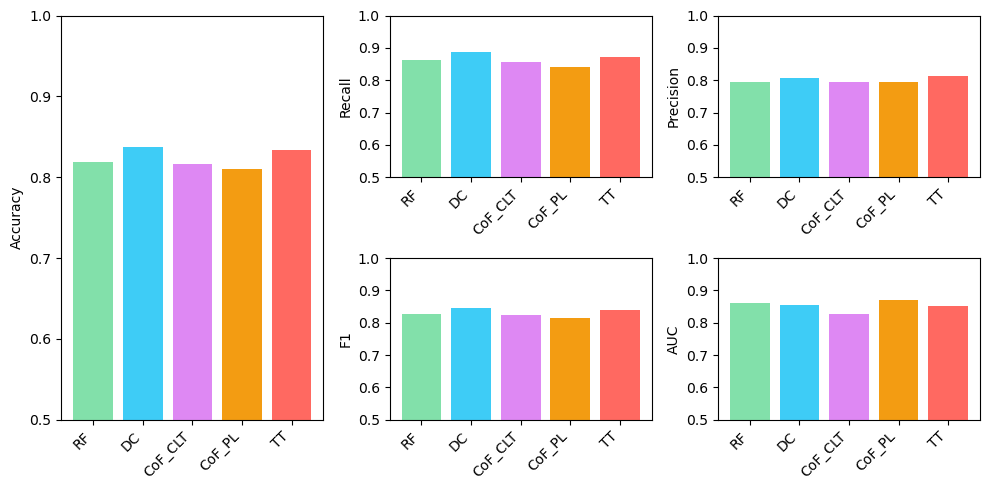

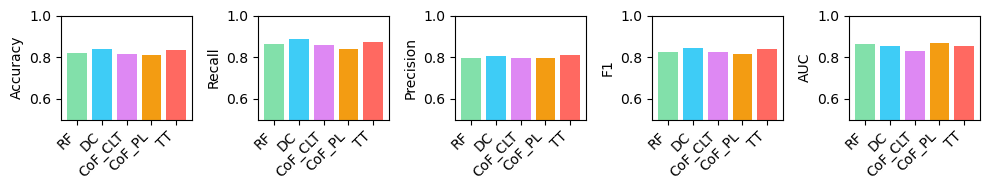

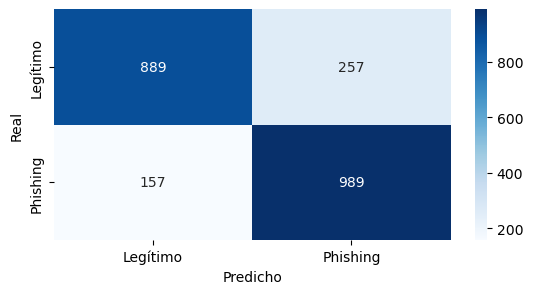

Matriz de confusión clasificador DC


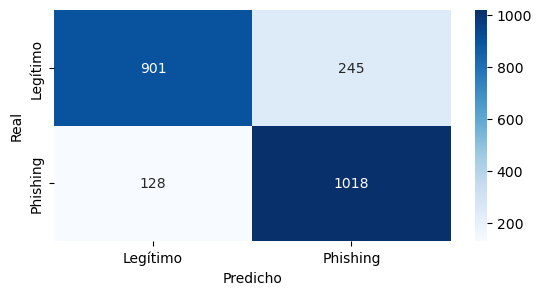

Matriz de confusión clasificador CoF_CLT


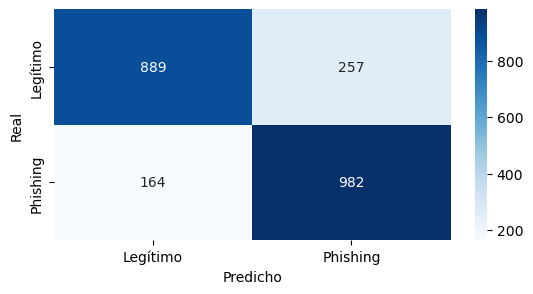

Matriz de confusión clasificador CoF_PL


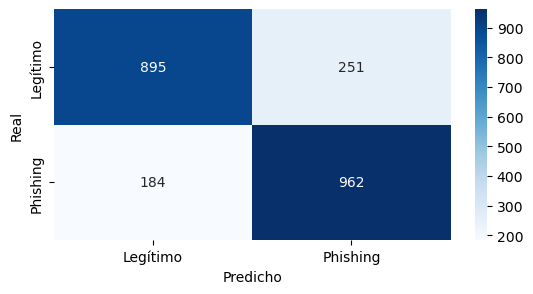

Matriz de confusión clasificador TT


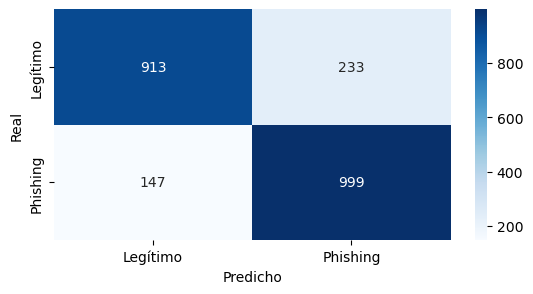

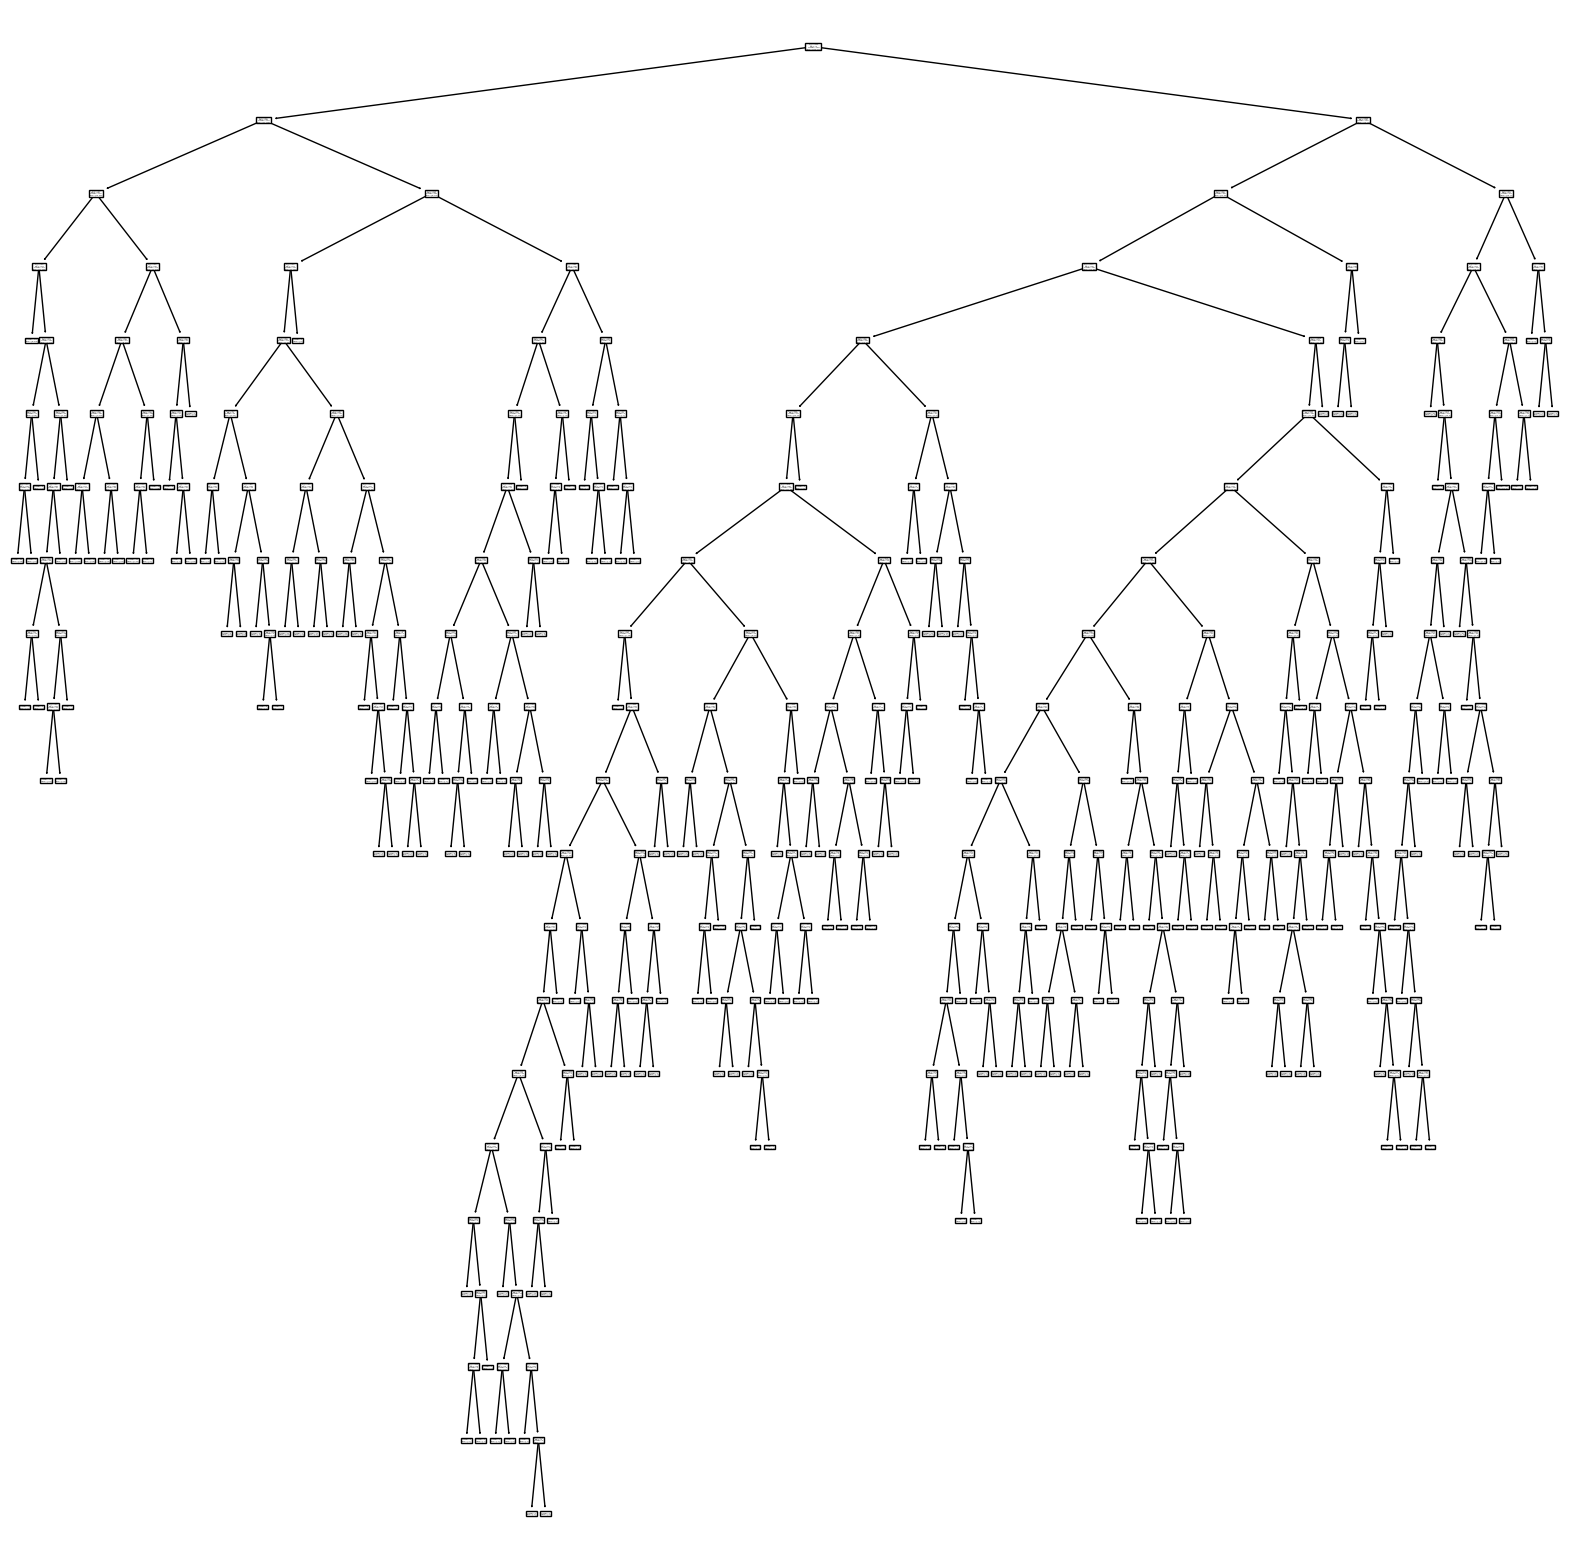

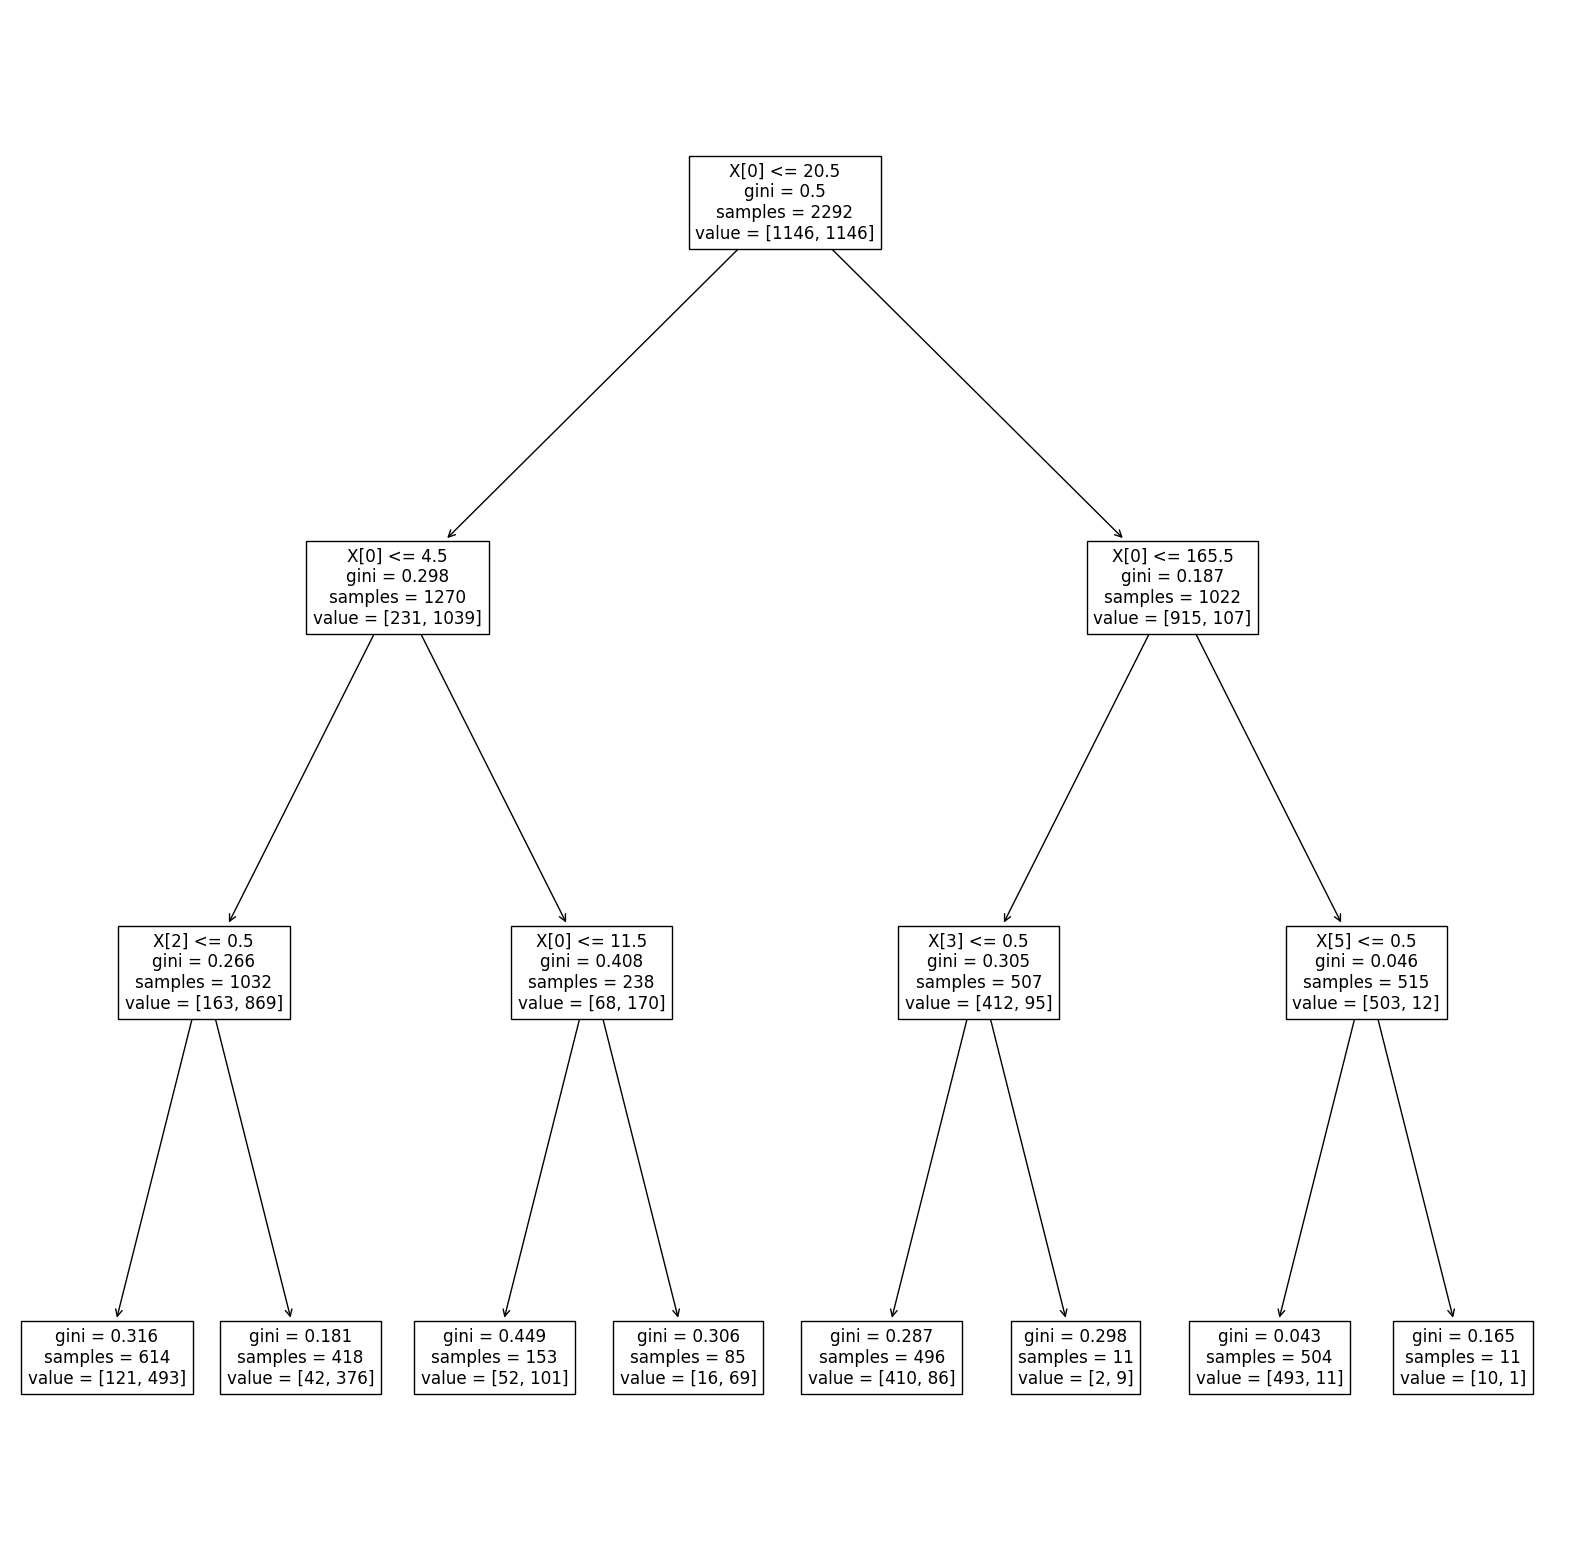

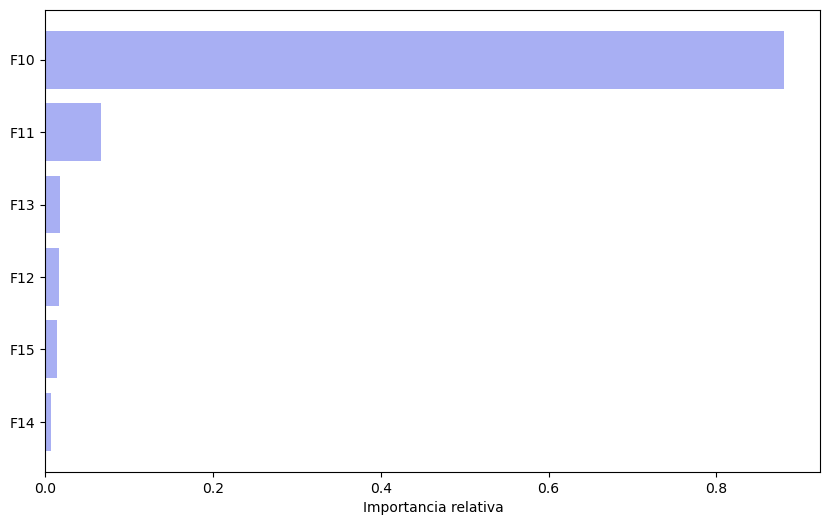

In [18]:
used_features = "F10-F15"
run_all(used_features)

Resultados F16
Matriz de confusión clasificador RF


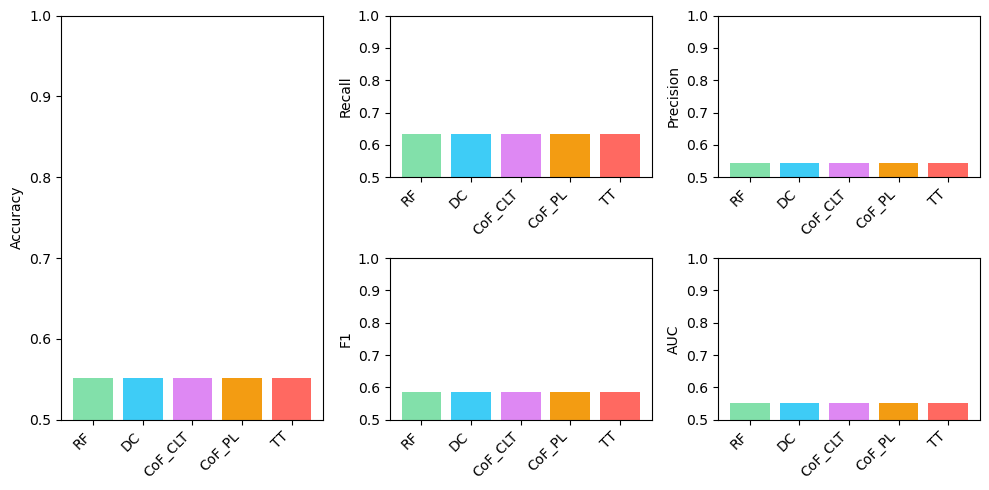

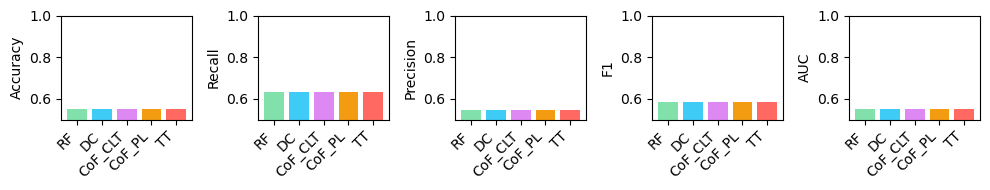

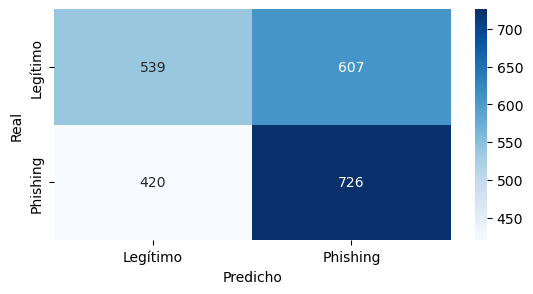

Matriz de confusión clasificador DC


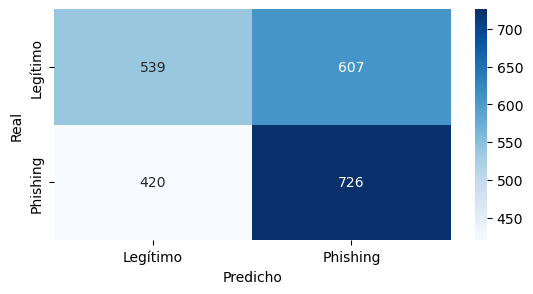

Matriz de confusión clasificador CoF_CLT


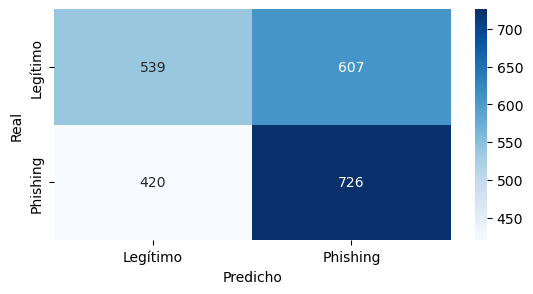

Matriz de confusión clasificador CoF_PL


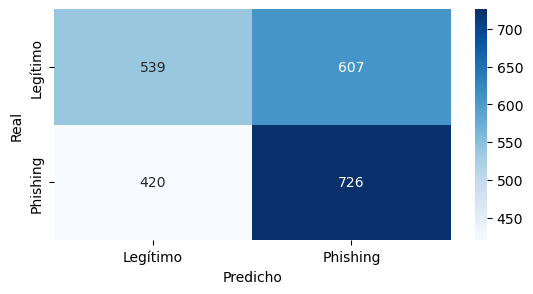

Matriz de confusión clasificador TT


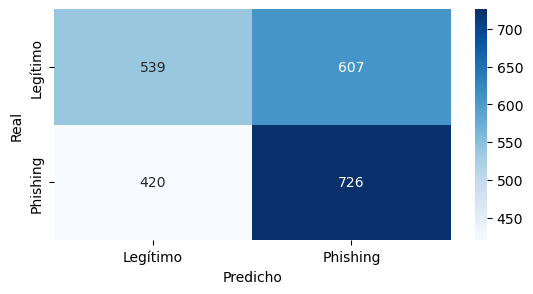

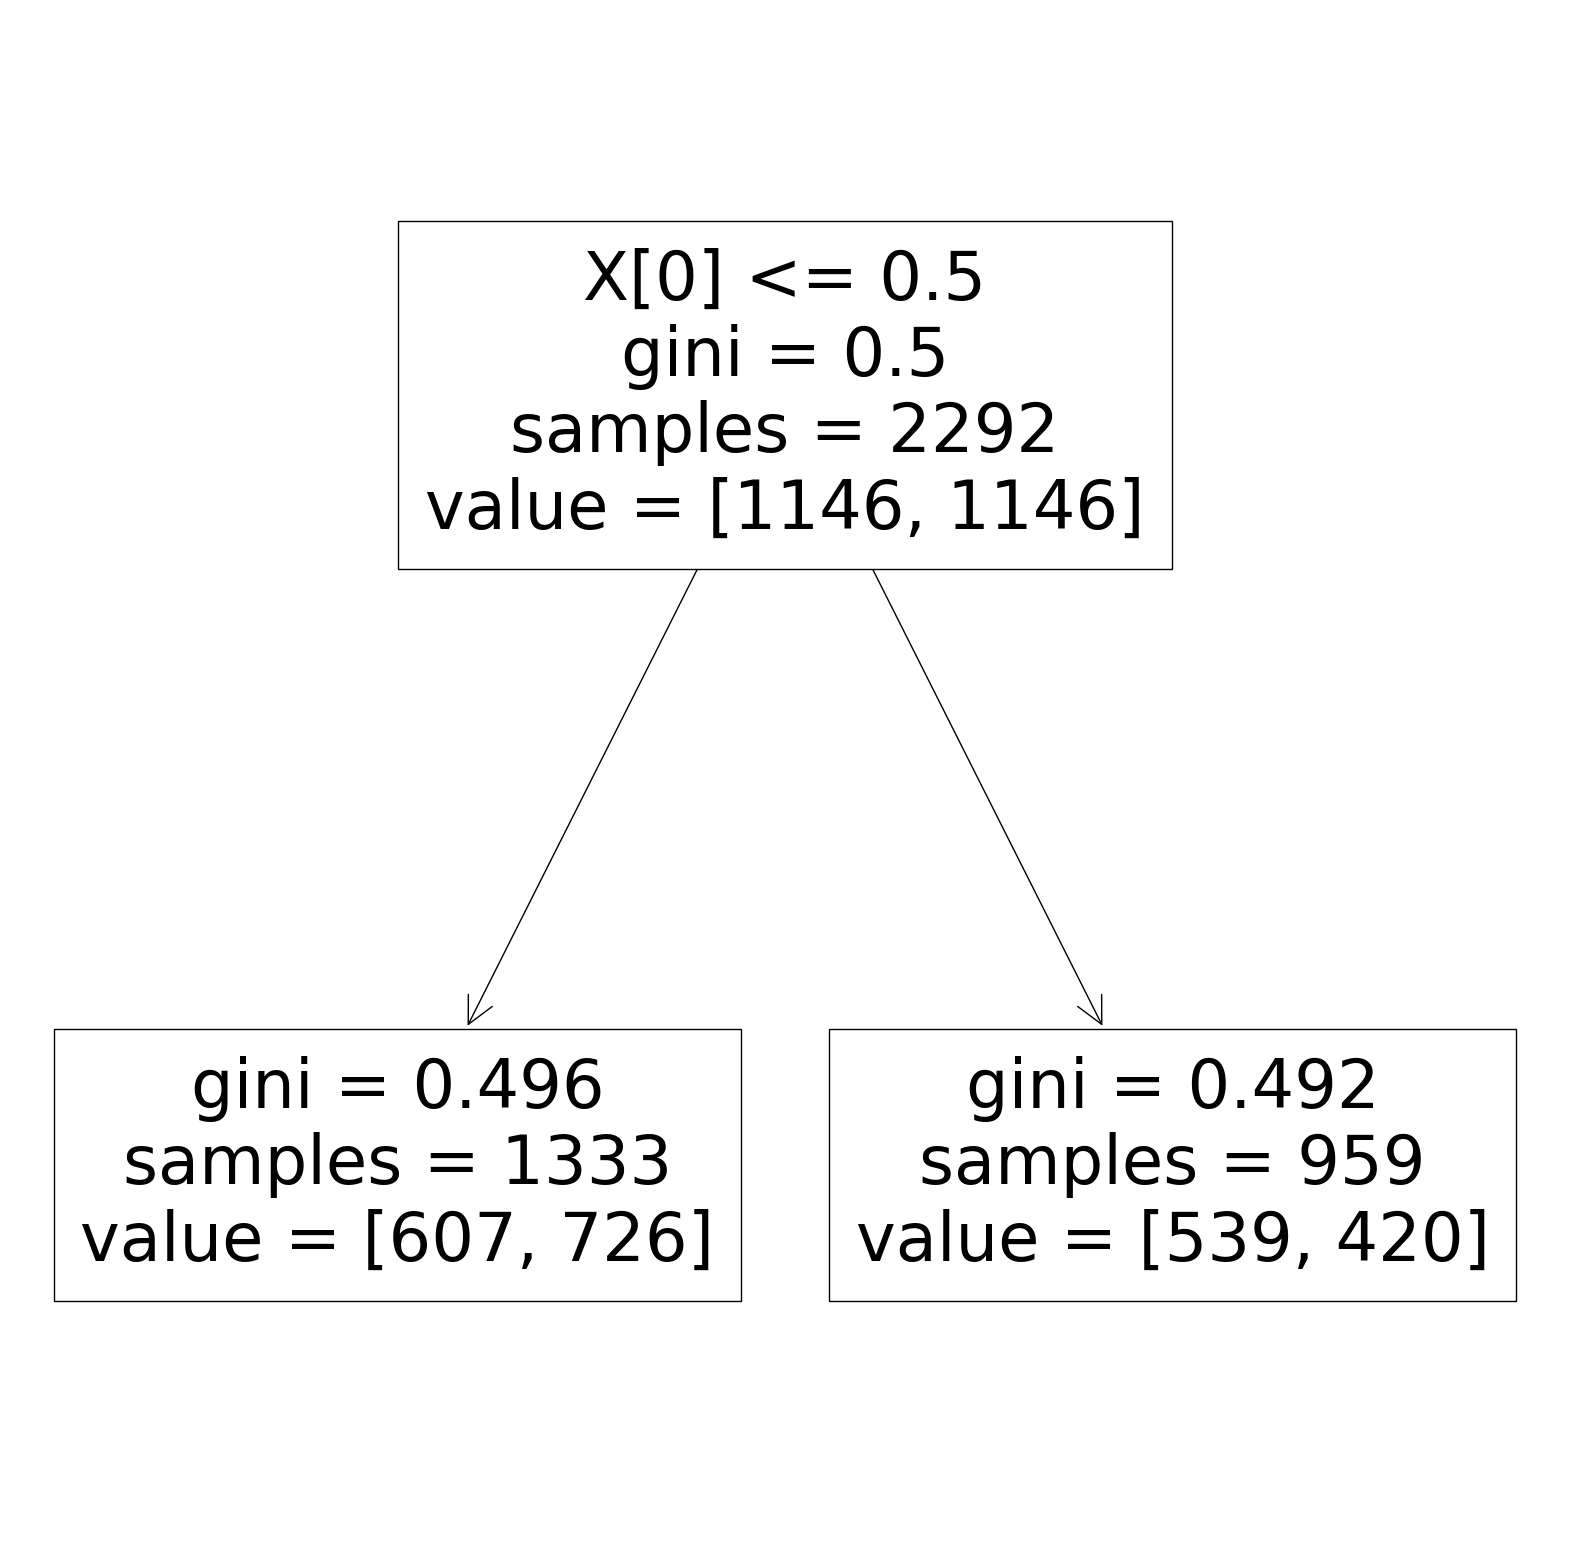

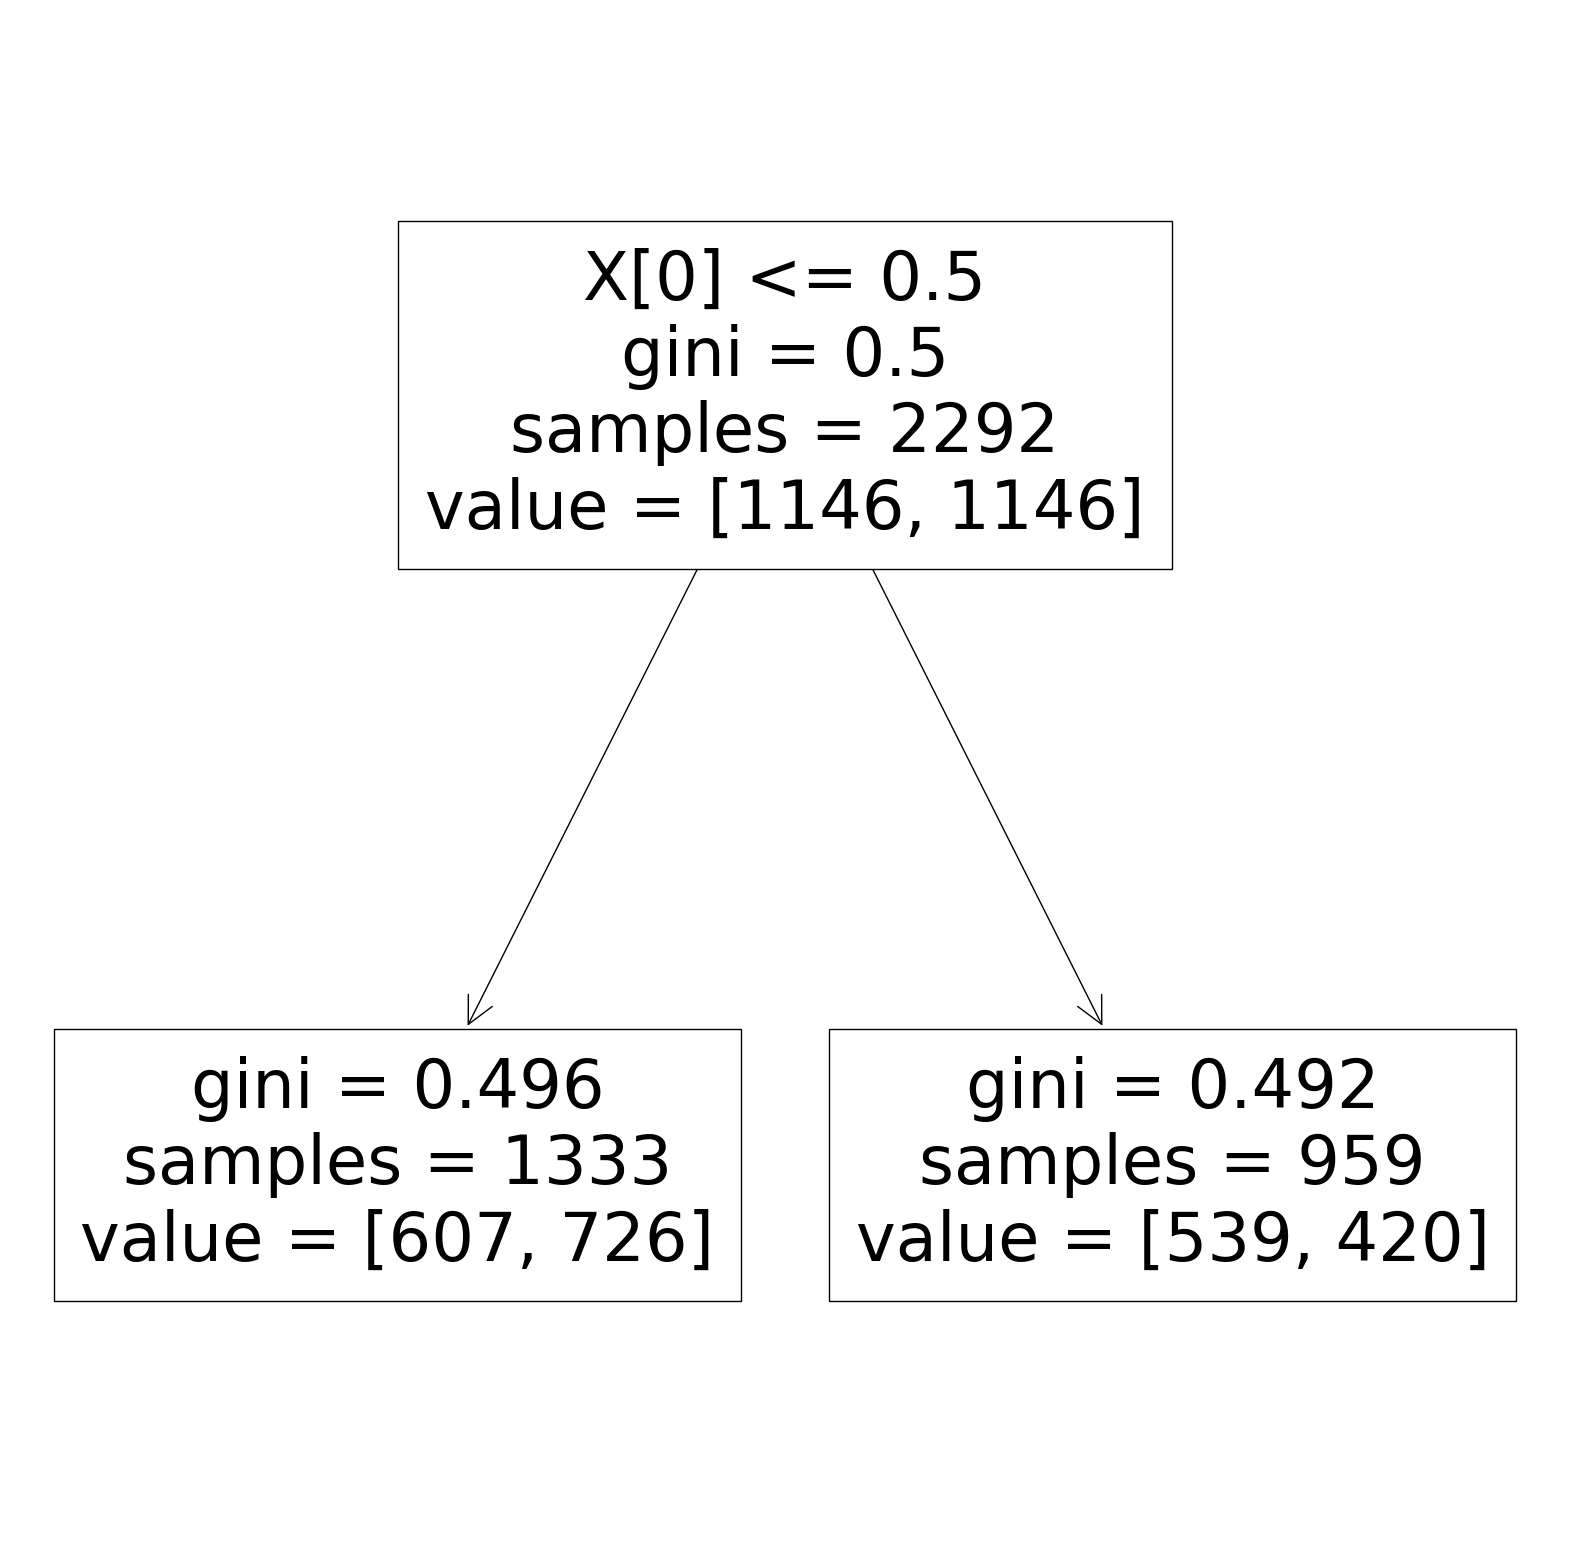

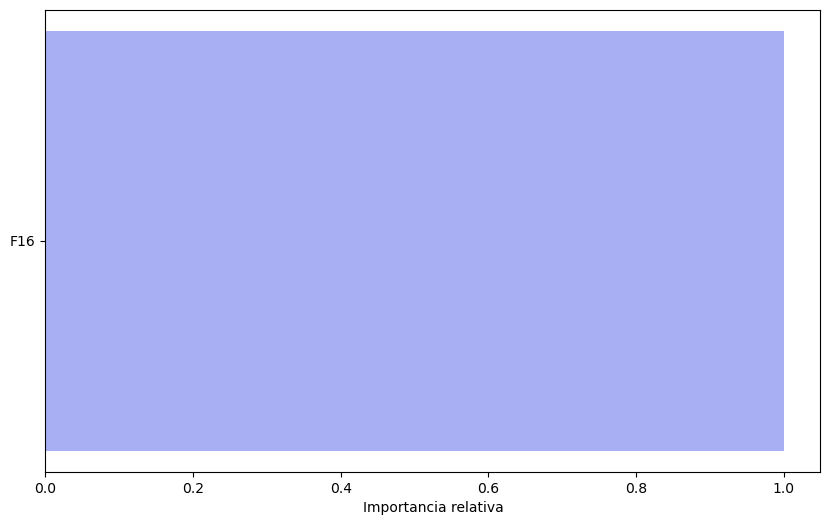

In [19]:
used_features = "F16"
run_all(used_features)

Resultados F17-F19
Matriz de confusión clasificador RF


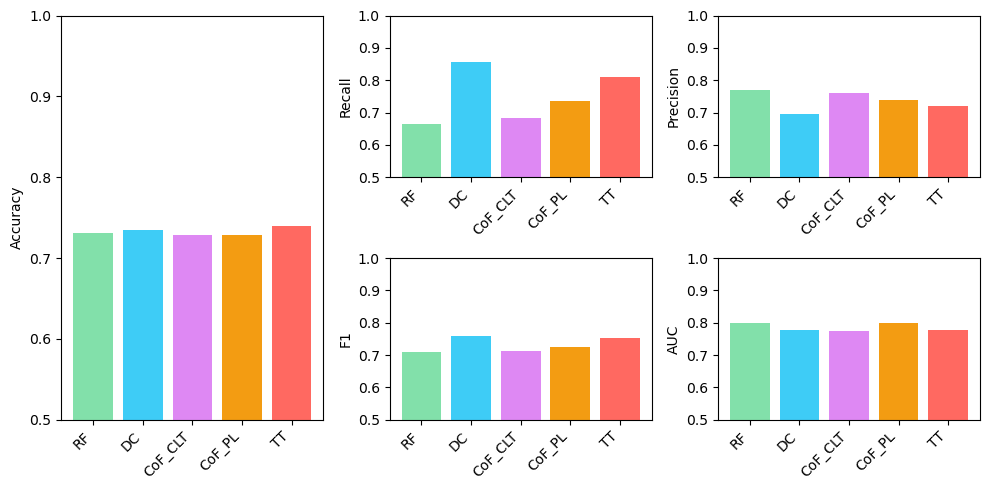

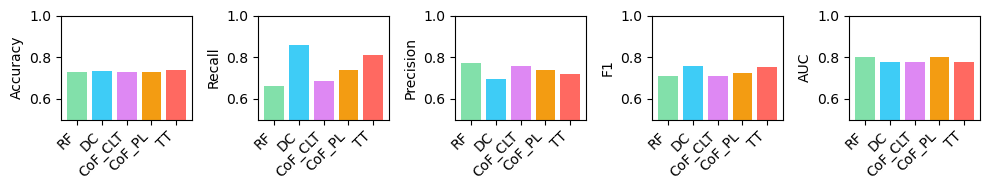

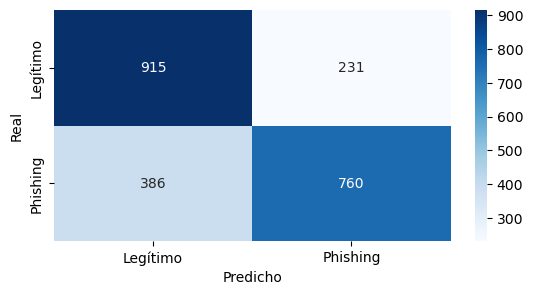

Matriz de confusión clasificador DC


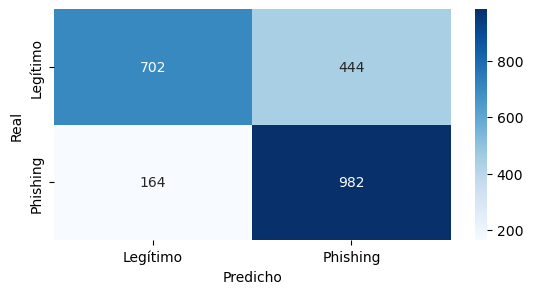

Matriz de confusión clasificador CoF_CLT


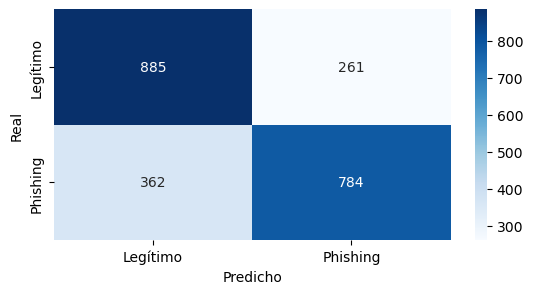

Matriz de confusión clasificador CoF_PL


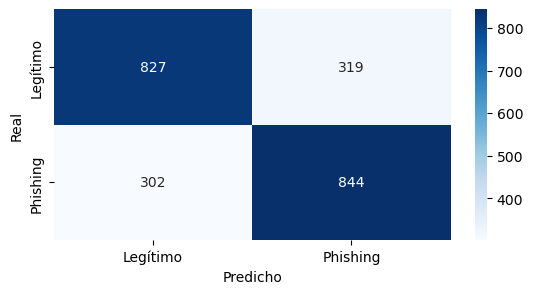

Matriz de confusión clasificador TT


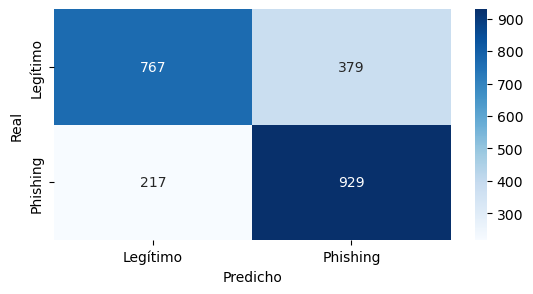

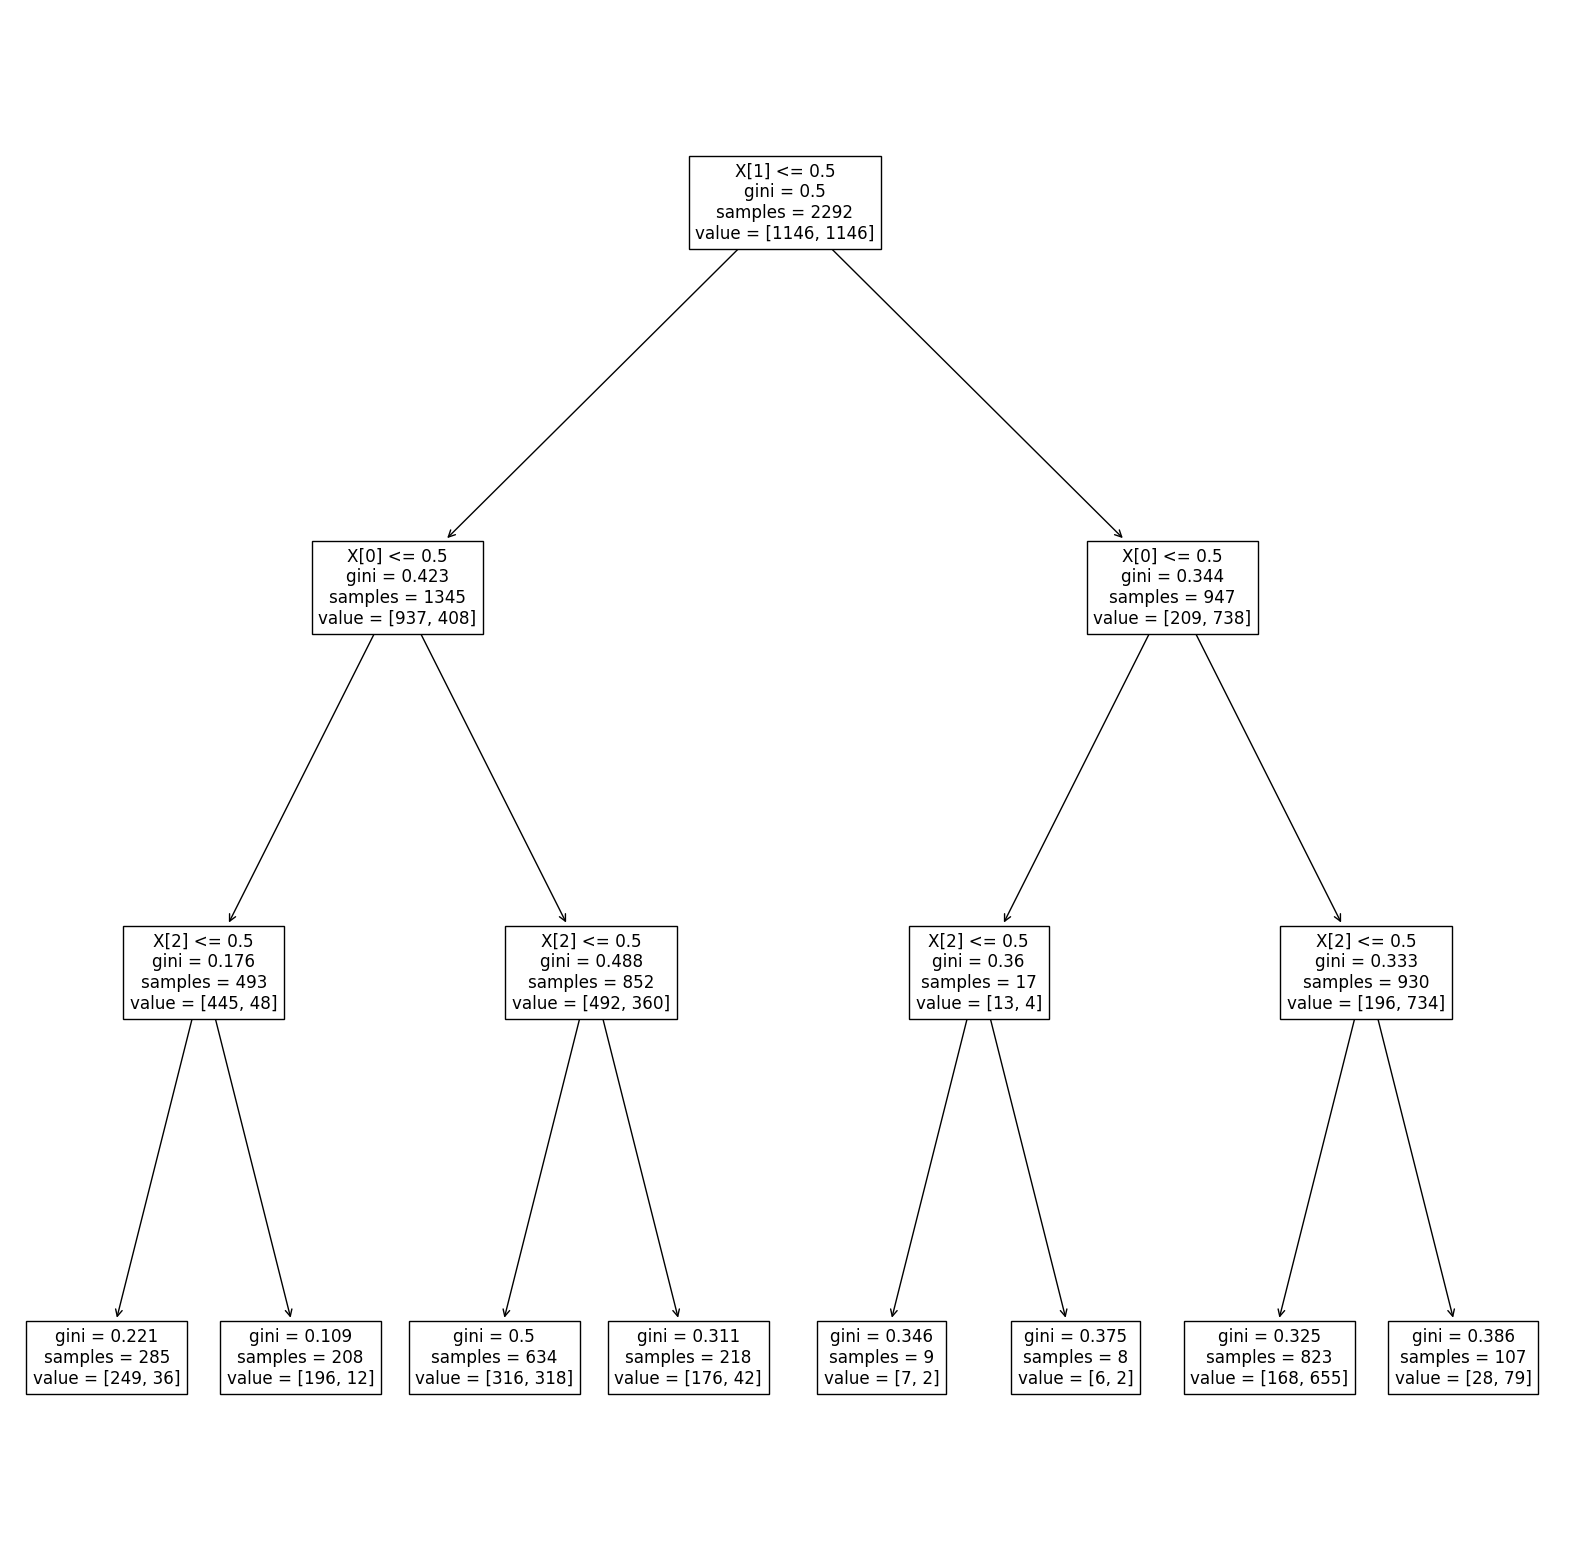

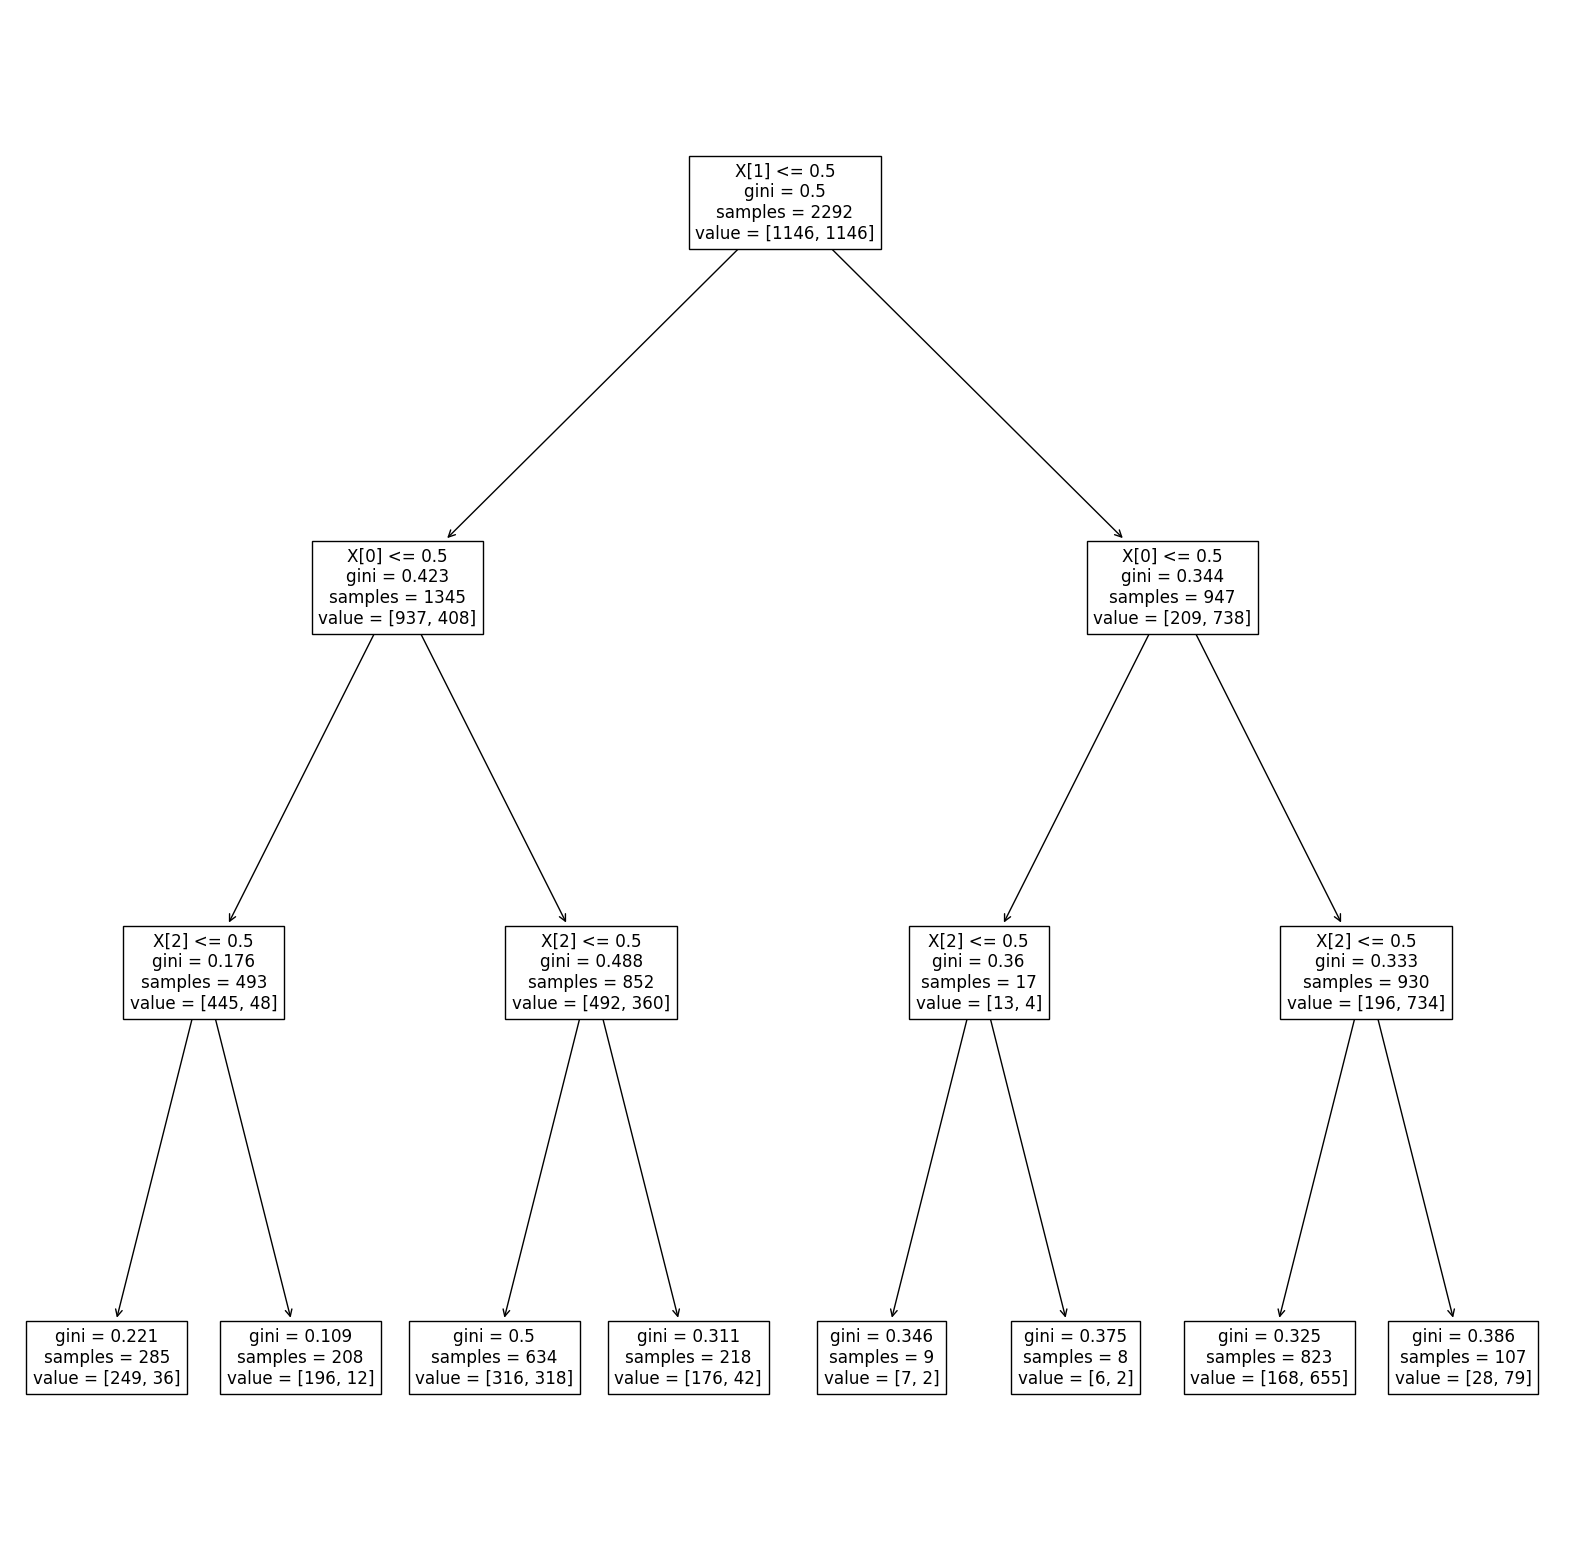

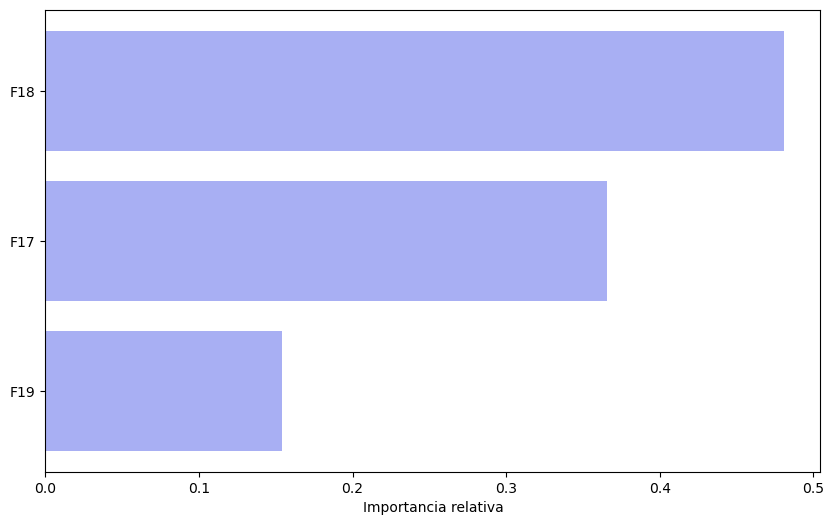

In [20]:
used_features = "F17-F19"
run_all(used_features)